# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

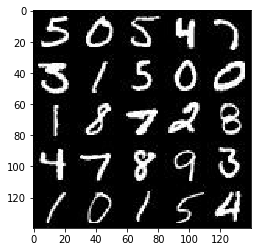

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

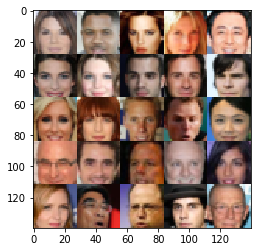

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/miniconda3/envs/dlnd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        x1 = tf.layers.conv2d(images, 32, 5, 2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=0.8)
        
        # 14x14x32
        x2 = tf.layers.conv2d(x1, 64, 5, 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.8)
        
        # 7x7x64
        x3 = tf.layers.conv2d(x2, 128, 5, 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.8)
        
        # 4x4x128
        x4 = tf.layers.conv2d(x3, 256, 5, 2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=0.8)
        
        flat = tf.reshape(x4, (-1, 4*4*128))
        # flat = tf.contrib.layers.flatten(x4)

        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    stddev = 0.02
    
    with tf.variable_scope('generator', reuse=not is_train):
        # 4x4x512
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=0.5)
        
        # 8x8x128
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, 1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.5)
        
        # 16x16x64
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.5)
        
        # 32x32x3
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=0.5)
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
#     d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
#                                                                          labels=tf.ones_like(d_model_real)))

    # try label smoothing
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*(1 - 0.1)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_e = 10
    show_e = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # The value range of the MNIST/CelebA dataset:-0.5 to 0.5. tanh output -1 to 1.
                batch_images *= 2

                # normaliz input images
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: sample_z, 
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: sample_z,
                                                     lr: learning_rate})
                # run the optimization for the generator twice to make sure the discriminator loss doesn't go to zero.
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: sample_z, 
                                                     lr: learning_rate})
                
                if steps % print_e == 0:
                    train_loss_d = d_loss.eval({input_z: sample_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: sample_z})
                    
                    print("Epoch {}/{}:\t".format(epoch_i+1, epoch_count),
                          "Discriminator loss: {:.3f}\t".format(train_loss_d),
                          "Generator loss: {:.3f}".format(train_loss_g))
                if steps % show_e == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2:	 Discriminator loss: 1.217	 Generator loss: 2.086
Epoch 1/2:	 Discriminator loss: 1.078	 Generator loss: 1.123
Epoch 1/2:	 Discriminator loss: 1.349	 Generator loss: 1.633
Epoch 1/2:	 Discriminator loss: 1.443	 Generator loss: 0.668
Epoch 1/2:	 Discriminator loss: 1.355	 Generator loss: 1.193
Epoch 1/2:	 Discriminator loss: 1.261	 Generator loss: 0.808
Epoch 1/2:	 Discriminator loss: 1.247	 Generator loss: 1.582
Epoch 1/2:	 Discriminator loss: 1.417	 Generator loss: 1.179
Epoch 1/2:	 Discriminator loss: 1.490	 Generator loss: 1.488
Epoch 1/2:	 Discriminator loss: 1.373	 Generator loss: 1.546


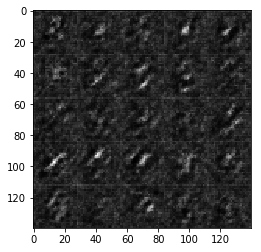

Epoch 1/2:	 Discriminator loss: 1.452	 Generator loss: 1.712
Epoch 1/2:	 Discriminator loss: 1.613	 Generator loss: 2.391
Epoch 1/2:	 Discriminator loss: 1.163	 Generator loss: 1.173
Epoch 1/2:	 Discriminator loss: 1.456	 Generator loss: 1.577
Epoch 1/2:	 Discriminator loss: 1.993	 Generator loss: 0.575
Epoch 1/2:	 Discriminator loss: 1.512	 Generator loss: 0.520
Epoch 1/2:	 Discriminator loss: 1.441	 Generator loss: 0.851
Epoch 1/2:	 Discriminator loss: 1.195	 Generator loss: 0.888
Epoch 1/2:	 Discriminator loss: 1.588	 Generator loss: 0.872
Epoch 1/2:	 Discriminator loss: 1.189	 Generator loss: 0.933


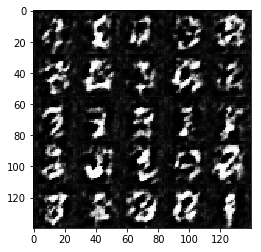

Epoch 1/2:	 Discriminator loss: 1.663	 Generator loss: 0.630
Epoch 1/2:	 Discriminator loss: 1.423	 Generator loss: 0.631
Epoch 1/2:	 Discriminator loss: 1.306	 Generator loss: 0.699
Epoch 1/2:	 Discriminator loss: 1.205	 Generator loss: 1.845
Epoch 1/2:	 Discriminator loss: 1.048	 Generator loss: 1.329
Epoch 1/2:	 Discriminator loss: 1.275	 Generator loss: 1.523
Epoch 1/2:	 Discriminator loss: 1.313	 Generator loss: 1.478
Epoch 1/2:	 Discriminator loss: 1.254	 Generator loss: 0.833
Epoch 1/2:	 Discriminator loss: 1.068	 Generator loss: 0.874
Epoch 1/2:	 Discriminator loss: 1.056	 Generator loss: 1.049


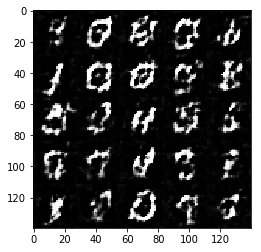

Epoch 1/2:	 Discriminator loss: 1.208	 Generator loss: 0.638
Epoch 1/2:	 Discriminator loss: 1.439	 Generator loss: 0.805
Epoch 1/2:	 Discriminator loss: 1.057	 Generator loss: 1.275
Epoch 1/2:	 Discriminator loss: 1.318	 Generator loss: 0.652
Epoch 1/2:	 Discriminator loss: 1.428	 Generator loss: 0.613
Epoch 1/2:	 Discriminator loss: 1.391	 Generator loss: 1.276
Epoch 1/2:	 Discriminator loss: 1.079	 Generator loss: 0.790
Epoch 1/2:	 Discriminator loss: 1.306	 Generator loss: 0.992
Epoch 1/2:	 Discriminator loss: 1.113	 Generator loss: 0.716
Epoch 1/2:	 Discriminator loss: 0.991	 Generator loss: 1.001


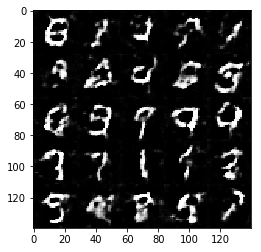

Epoch 1/2:	 Discriminator loss: 1.138	 Generator loss: 1.012
Epoch 1/2:	 Discriminator loss: 1.090	 Generator loss: 1.371
Epoch 1/2:	 Discriminator loss: 1.158	 Generator loss: 0.696
Epoch 1/2:	 Discriminator loss: 1.004	 Generator loss: 0.775
Epoch 1/2:	 Discriminator loss: 1.396	 Generator loss: 0.924
Epoch 1/2:	 Discriminator loss: 1.083	 Generator loss: 1.003
Epoch 1/2:	 Discriminator loss: 1.110	 Generator loss: 1.013
Epoch 1/2:	 Discriminator loss: 1.164	 Generator loss: 1.797
Epoch 1/2:	 Discriminator loss: 1.137	 Generator loss: 1.003
Epoch 1/2:	 Discriminator loss: 1.467	 Generator loss: 0.592


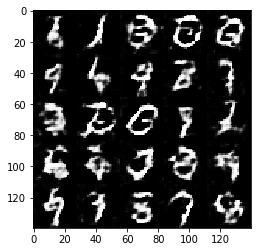

Epoch 1/2:	 Discriminator loss: 1.238	 Generator loss: 0.747
Epoch 1/2:	 Discriminator loss: 1.869	 Generator loss: 0.412
Epoch 1/2:	 Discriminator loss: 1.308	 Generator loss: 0.506
Epoch 1/2:	 Discriminator loss: 1.237	 Generator loss: 0.762
Epoch 1/2:	 Discriminator loss: 1.147	 Generator loss: 0.530
Epoch 1/2:	 Discriminator loss: 1.341	 Generator loss: 2.319
Epoch 1/2:	 Discriminator loss: 1.039	 Generator loss: 1.105
Epoch 1/2:	 Discriminator loss: 1.084	 Generator loss: 1.288
Epoch 1/2:	 Discriminator loss: 1.349	 Generator loss: 0.511
Epoch 1/2:	 Discriminator loss: 1.090	 Generator loss: 1.417


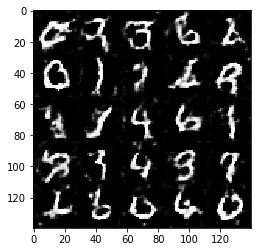

Epoch 1/2:	 Discriminator loss: 0.909	 Generator loss: 1.190
Epoch 1/2:	 Discriminator loss: 1.016	 Generator loss: 1.323
Epoch 1/2:	 Discriminator loss: 1.113	 Generator loss: 2.171
Epoch 1/2:	 Discriminator loss: 1.299	 Generator loss: 0.802
Epoch 1/2:	 Discriminator loss: 1.340	 Generator loss: 1.481
Epoch 1/2:	 Discriminator loss: 1.111	 Generator loss: 1.409
Epoch 1/2:	 Discriminator loss: 1.158	 Generator loss: 1.660
Epoch 1/2:	 Discriminator loss: 0.957	 Generator loss: 0.913
Epoch 1/2:	 Discriminator loss: 1.117	 Generator loss: 1.269
Epoch 1/2:	 Discriminator loss: 0.941	 Generator loss: 1.670


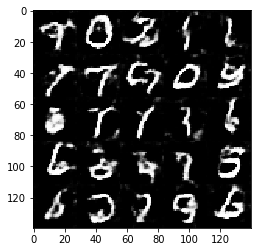

Epoch 1/2:	 Discriminator loss: 1.084	 Generator loss: 1.065
Epoch 1/2:	 Discriminator loss: 1.127	 Generator loss: 0.580
Epoch 1/2:	 Discriminator loss: 1.225	 Generator loss: 1.306
Epoch 1/2:	 Discriminator loss: 1.246	 Generator loss: 0.434
Epoch 1/2:	 Discriminator loss: 0.901	 Generator loss: 0.798
Epoch 1/2:	 Discriminator loss: 1.251	 Generator loss: 0.636
Epoch 1/2:	 Discriminator loss: 1.016	 Generator loss: 1.332
Epoch 1/2:	 Discriminator loss: 1.232	 Generator loss: 0.834
Epoch 1/2:	 Discriminator loss: 1.221	 Generator loss: 0.981
Epoch 1/2:	 Discriminator loss: 1.127	 Generator loss: 1.673


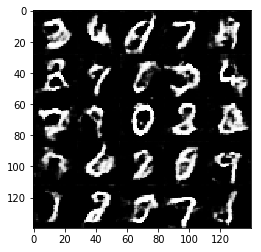

Epoch 1/2:	 Discriminator loss: 1.110	 Generator loss: 0.872
Epoch 1/2:	 Discriminator loss: 0.952	 Generator loss: 1.102
Epoch 1/2:	 Discriminator loss: 1.210	 Generator loss: 0.752
Epoch 1/2:	 Discriminator loss: 1.007	 Generator loss: 1.047
Epoch 1/2:	 Discriminator loss: 1.641	 Generator loss: 0.456
Epoch 1/2:	 Discriminator loss: 0.907	 Generator loss: 1.301
Epoch 1/2:	 Discriminator loss: 1.003	 Generator loss: 1.038
Epoch 1/2:	 Discriminator loss: 0.928	 Generator loss: 1.599
Epoch 1/2:	 Discriminator loss: 1.178	 Generator loss: 0.907
Epoch 1/2:	 Discriminator loss: 1.227	 Generator loss: 1.163


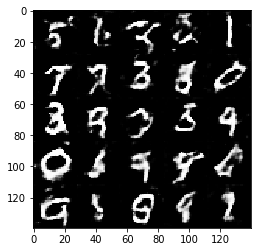

Epoch 1/2:	 Discriminator loss: 0.842	 Generator loss: 1.156
Epoch 1/2:	 Discriminator loss: 1.210	 Generator loss: 1.143
Epoch 1/2:	 Discriminator loss: 1.063	 Generator loss: 0.749
Epoch 1/2:	 Discriminator loss: 1.116	 Generator loss: 0.707
Epoch 1/2:	 Discriminator loss: 1.375	 Generator loss: 0.812
Epoch 1/2:	 Discriminator loss: 0.891	 Generator loss: 1.614
Epoch 1/2:	 Discriminator loss: 0.845	 Generator loss: 1.064
Epoch 1/2:	 Discriminator loss: 0.972	 Generator loss: 1.446
Epoch 1/2:	 Discriminator loss: 1.088	 Generator loss: 1.432
Epoch 1/2:	 Discriminator loss: 1.026	 Generator loss: 1.901


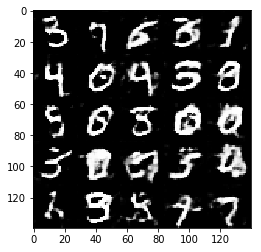

Epoch 1/2:	 Discriminator loss: 1.111	 Generator loss: 1.125
Epoch 1/2:	 Discriminator loss: 0.971	 Generator loss: 1.578
Epoch 1/2:	 Discriminator loss: 1.065	 Generator loss: 1.225
Epoch 1/2:	 Discriminator loss: 0.969	 Generator loss: 0.951
Epoch 1/2:	 Discriminator loss: 1.126	 Generator loss: 1.164
Epoch 1/2:	 Discriminator loss: 1.644	 Generator loss: 3.486
Epoch 1/2:	 Discriminator loss: 0.693	 Generator loss: 0.977
Epoch 1/2:	 Discriminator loss: 1.048	 Generator loss: 0.771
Epoch 1/2:	 Discriminator loss: 0.975	 Generator loss: 1.115
Epoch 1/2:	 Discriminator loss: 0.950	 Generator loss: 2.791


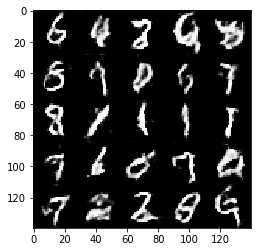

Epoch 1/2:	 Discriminator loss: 1.252	 Generator loss: 2.640
Epoch 1/2:	 Discriminator loss: 0.979	 Generator loss: 1.258
Epoch 1/2:	 Discriminator loss: 1.094	 Generator loss: 0.656
Epoch 1/2:	 Discriminator loss: 1.577	 Generator loss: 0.412
Epoch 1/2:	 Discriminator loss: 0.904	 Generator loss: 0.867
Epoch 1/2:	 Discriminator loss: 0.856	 Generator loss: 1.142
Epoch 1/2:	 Discriminator loss: 1.201	 Generator loss: 0.431
Epoch 1/2:	 Discriminator loss: 0.884	 Generator loss: 0.652
Epoch 1/2:	 Discriminator loss: 0.806	 Generator loss: 1.535
Epoch 1/2:	 Discriminator loss: 0.894	 Generator loss: 1.812


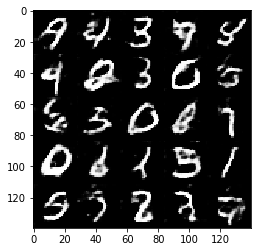

Epoch 1/2:	 Discriminator loss: 0.850	 Generator loss: 0.963
Epoch 1/2:	 Discriminator loss: 0.830	 Generator loss: 1.248
Epoch 1/2:	 Discriminator loss: 1.009	 Generator loss: 1.525
Epoch 1/2:	 Discriminator loss: 1.122	 Generator loss: 0.722
Epoch 1/2:	 Discriminator loss: 0.843	 Generator loss: 1.074
Epoch 1/2:	 Discriminator loss: 1.356	 Generator loss: 0.747
Epoch 1/2:	 Discriminator loss: 0.945	 Generator loss: 1.782
Epoch 1/2:	 Discriminator loss: 0.577	 Generator loss: 1.390
Epoch 1/2:	 Discriminator loss: 0.909	 Generator loss: 1.470
Epoch 1/2:	 Discriminator loss: 1.282	 Generator loss: 0.792


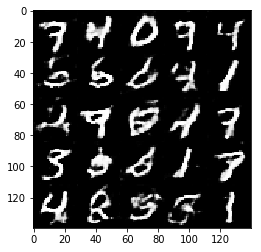

Epoch 1/2:	 Discriminator loss: 1.031	 Generator loss: 1.051
Epoch 1/2:	 Discriminator loss: 0.810	 Generator loss: 1.043
Epoch 1/2:	 Discriminator loss: 0.958	 Generator loss: 0.815
Epoch 1/2:	 Discriminator loss: 1.232	 Generator loss: 0.671
Epoch 1/2:	 Discriminator loss: 0.968	 Generator loss: 0.998
Epoch 1/2:	 Discriminator loss: 0.689	 Generator loss: 1.767
Epoch 1/2:	 Discriminator loss: 0.841	 Generator loss: 1.505
Epoch 1/2:	 Discriminator loss: 1.615	 Generator loss: 0.547
Epoch 1/2:	 Discriminator loss: 0.862	 Generator loss: 0.881
Epoch 1/2:	 Discriminator loss: 1.175	 Generator loss: 1.239


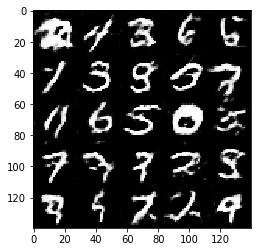

Epoch 1/2:	 Discriminator loss: 1.171	 Generator loss: 0.807
Epoch 1/2:	 Discriminator loss: 1.057	 Generator loss: 1.265
Epoch 1/2:	 Discriminator loss: 0.943	 Generator loss: 1.416
Epoch 1/2:	 Discriminator loss: 1.258	 Generator loss: 2.672
Epoch 1/2:	 Discriminator loss: 1.131	 Generator loss: 1.214
Epoch 1/2:	 Discriminator loss: 1.478	 Generator loss: 0.625
Epoch 1/2:	 Discriminator loss: 0.785	 Generator loss: 1.340
Epoch 1/2:	 Discriminator loss: 0.801	 Generator loss: 1.772
Epoch 1/2:	 Discriminator loss: 1.774	 Generator loss: 0.342
Epoch 1/2:	 Discriminator loss: 0.848	 Generator loss: 0.825


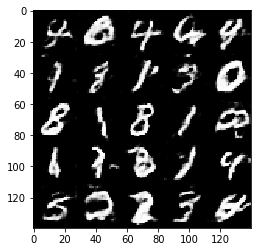

Epoch 1/2:	 Discriminator loss: 1.488	 Generator loss: 2.617
Epoch 1/2:	 Discriminator loss: 1.427	 Generator loss: 0.766
Epoch 1/2:	 Discriminator loss: 1.097	 Generator loss: 0.715
Epoch 1/2:	 Discriminator loss: 1.193	 Generator loss: 1.741
Epoch 1/2:	 Discriminator loss: 1.069	 Generator loss: 0.863
Epoch 1/2:	 Discriminator loss: 0.736	 Generator loss: 1.506
Epoch 1/2:	 Discriminator loss: 0.887	 Generator loss: 1.283
Epoch 1/2:	 Discriminator loss: 0.884	 Generator loss: 1.505
Epoch 1/2:	 Discriminator loss: 0.933	 Generator loss: 1.189
Epoch 1/2:	 Discriminator loss: 0.796	 Generator loss: 1.126


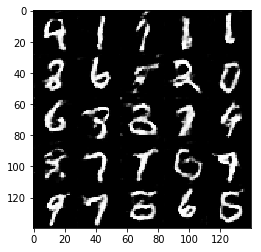

Epoch 1/2:	 Discriminator loss: 1.045	 Generator loss: 0.887
Epoch 1/2:	 Discriminator loss: 0.970	 Generator loss: 1.276
Epoch 1/2:	 Discriminator loss: 1.044	 Generator loss: 1.983
Epoch 1/2:	 Discriminator loss: 0.692	 Generator loss: 0.797
Epoch 1/2:	 Discriminator loss: 0.747	 Generator loss: 0.474
Epoch 1/2:	 Discriminator loss: 1.085	 Generator loss: 2.425
Epoch 1/2:	 Discriminator loss: 1.054	 Generator loss: 1.381
Epoch 1/2:	 Discriminator loss: 1.282	 Generator loss: 0.956
Epoch 1/2:	 Discriminator loss: 0.870	 Generator loss: 0.998
Epoch 1/2:	 Discriminator loss: 0.823	 Generator loss: 1.483


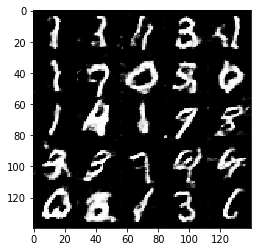

Epoch 1/2:	 Discriminator loss: 2.269	 Generator loss: 4.051
Epoch 1/2:	 Discriminator loss: 1.020	 Generator loss: 0.783
Epoch 1/2:	 Discriminator loss: 0.556	 Generator loss: 1.887
Epoch 1/2:	 Discriminator loss: 1.912	 Generator loss: 0.448
Epoch 1/2:	 Discriminator loss: 0.821	 Generator loss: 1.076
Epoch 1/2:	 Discriminator loss: 0.886	 Generator loss: 2.384
Epoch 1/2:	 Discriminator loss: 0.719	 Generator loss: 1.955
Epoch 1/2:	 Discriminator loss: 0.794	 Generator loss: 0.837
Epoch 1/2:	 Discriminator loss: 0.655	 Generator loss: 1.469
Epoch 1/2:	 Discriminator loss: 0.709	 Generator loss: 2.303


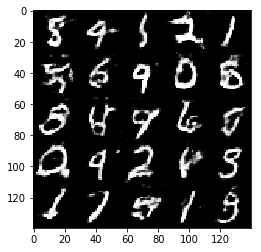

Epoch 1/2:	 Discriminator loss: 1.178	 Generator loss: 0.671
Epoch 1/2:	 Discriminator loss: 0.726	 Generator loss: 1.060
Epoch 1/2:	 Discriminator loss: 0.817	 Generator loss: 0.713
Epoch 1/2:	 Discriminator loss: 0.645	 Generator loss: 0.992
Epoch 1/2:	 Discriminator loss: 0.829	 Generator loss: 1.904
Epoch 1/2:	 Discriminator loss: 0.963	 Generator loss: 1.984
Epoch 1/2:	 Discriminator loss: 0.814	 Generator loss: 1.804
Epoch 2/2:	 Discriminator loss: 1.709	 Generator loss: 3.336
Epoch 2/2:	 Discriminator loss: 0.748	 Generator loss: 3.616
Epoch 2/2:	 Discriminator loss: 0.547	 Generator loss: 1.947


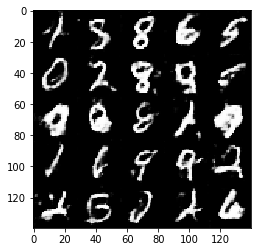

Epoch 2/2:	 Discriminator loss: 1.093	 Generator loss: 1.518
Epoch 2/2:	 Discriminator loss: 1.143	 Generator loss: 2.356
Epoch 2/2:	 Discriminator loss: 0.798	 Generator loss: 1.582
Epoch 2/2:	 Discriminator loss: 0.879	 Generator loss: 1.266
Epoch 2/2:	 Discriminator loss: 0.966	 Generator loss: 1.297
Epoch 2/2:	 Discriminator loss: 0.792	 Generator loss: 2.147
Epoch 2/2:	 Discriminator loss: 0.714	 Generator loss: 0.644
Epoch 2/2:	 Discriminator loss: 1.006	 Generator loss: 3.034
Epoch 2/2:	 Discriminator loss: 0.610	 Generator loss: 1.571
Epoch 2/2:	 Discriminator loss: 0.988	 Generator loss: 2.139


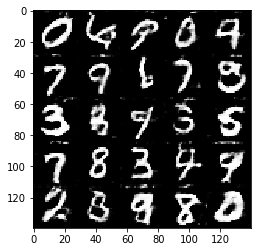

Epoch 2/2:	 Discriminator loss: 1.597	 Generator loss: 1.211
Epoch 2/2:	 Discriminator loss: 0.663	 Generator loss: 1.741
Epoch 2/2:	 Discriminator loss: 0.571	 Generator loss: 2.537
Epoch 2/2:	 Discriminator loss: 0.923	 Generator loss: 1.001
Epoch 2/2:	 Discriminator loss: 0.674	 Generator loss: 1.327
Epoch 2/2:	 Discriminator loss: 0.704	 Generator loss: 2.791
Epoch 2/2:	 Discriminator loss: 1.206	 Generator loss: 0.865
Epoch 2/2:	 Discriminator loss: 0.491	 Generator loss: 1.727
Epoch 2/2:	 Discriminator loss: 0.826	 Generator loss: 1.254
Epoch 2/2:	 Discriminator loss: 0.851	 Generator loss: 1.176


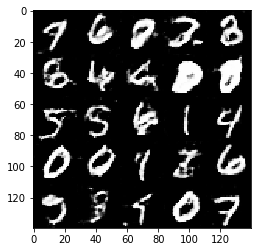

Epoch 2/2:	 Discriminator loss: 0.677	 Generator loss: 1.325
Epoch 2/2:	 Discriminator loss: 0.806	 Generator loss: 1.522
Epoch 2/2:	 Discriminator loss: 0.767	 Generator loss: 2.076
Epoch 2/2:	 Discriminator loss: 0.604	 Generator loss: 2.036
Epoch 2/2:	 Discriminator loss: 0.694	 Generator loss: 1.677
Epoch 2/2:	 Discriminator loss: 1.024	 Generator loss: 0.435
Epoch 2/2:	 Discriminator loss: 0.796	 Generator loss: 1.919
Epoch 2/2:	 Discriminator loss: 0.943	 Generator loss: 1.236
Epoch 2/2:	 Discriminator loss: 0.759	 Generator loss: 2.092
Epoch 2/2:	 Discriminator loss: 1.522	 Generator loss: 0.970


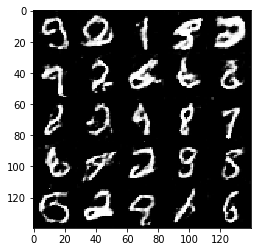

Epoch 2/2:	 Discriminator loss: 0.730	 Generator loss: 1.463
Epoch 2/2:	 Discriminator loss: 0.560	 Generator loss: 2.803
Epoch 2/2:	 Discriminator loss: 0.874	 Generator loss: 3.483
Epoch 2/2:	 Discriminator loss: 0.815	 Generator loss: 0.801
Epoch 2/2:	 Discriminator loss: 1.527	 Generator loss: 0.424
Epoch 2/2:	 Discriminator loss: 1.373	 Generator loss: 0.468
Epoch 2/2:	 Discriminator loss: 0.864	 Generator loss: 1.311
Epoch 2/2:	 Discriminator loss: 0.655	 Generator loss: 1.248
Epoch 2/2:	 Discriminator loss: 0.853	 Generator loss: 0.851
Epoch 2/2:	 Discriminator loss: 1.104	 Generator loss: 0.669


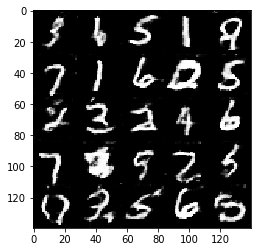

Epoch 2/2:	 Discriminator loss: 0.731	 Generator loss: 1.781
Epoch 2/2:	 Discriminator loss: 1.094	 Generator loss: 0.491
Epoch 2/2:	 Discriminator loss: 0.518	 Generator loss: 1.603
Epoch 2/2:	 Discriminator loss: 0.624	 Generator loss: 1.520
Epoch 2/2:	 Discriminator loss: 0.795	 Generator loss: 1.107
Epoch 2/2:	 Discriminator loss: 0.538	 Generator loss: 1.902
Epoch 2/2:	 Discriminator loss: 1.871	 Generator loss: 0.515
Epoch 2/2:	 Discriminator loss: 0.793	 Generator loss: 1.516
Epoch 2/2:	 Discriminator loss: 0.866	 Generator loss: 1.672
Epoch 2/2:	 Discriminator loss: 0.565	 Generator loss: 1.429


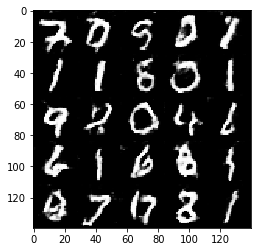

Epoch 2/2:	 Discriminator loss: 1.015	 Generator loss: 1.480
Epoch 2/2:	 Discriminator loss: 0.671	 Generator loss: 2.384
Epoch 2/2:	 Discriminator loss: 0.735	 Generator loss: 0.821
Epoch 2/2:	 Discriminator loss: 0.993	 Generator loss: 1.158
Epoch 2/2:	 Discriminator loss: 1.270	 Generator loss: 0.598
Epoch 2/2:	 Discriminator loss: 1.796	 Generator loss: 0.779
Epoch 2/2:	 Discriminator loss: 0.853	 Generator loss: 1.653
Epoch 2/2:	 Discriminator loss: 1.500	 Generator loss: 1.077
Epoch 2/2:	 Discriminator loss: 0.591	 Generator loss: 2.232
Epoch 2/2:	 Discriminator loss: 1.596	 Generator loss: 0.574


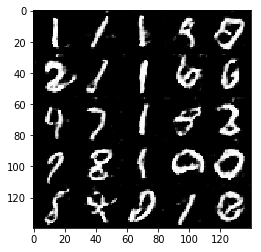

Epoch 2/2:	 Discriminator loss: 1.558	 Generator loss: 0.918
Epoch 2/2:	 Discriminator loss: 0.738	 Generator loss: 1.425
Epoch 2/2:	 Discriminator loss: 0.434	 Generator loss: 2.269
Epoch 2/2:	 Discriminator loss: 1.082	 Generator loss: 0.820
Epoch 2/2:	 Discriminator loss: 0.592	 Generator loss: 2.706
Epoch 2/2:	 Discriminator loss: 0.714	 Generator loss: 1.821
Epoch 2/2:	 Discriminator loss: 0.650	 Generator loss: 1.947
Epoch 2/2:	 Discriminator loss: 0.750	 Generator loss: 1.002
Epoch 2/2:	 Discriminator loss: 0.897	 Generator loss: 4.115
Epoch 2/2:	 Discriminator loss: 0.558	 Generator loss: 2.123


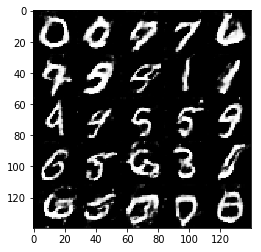

Epoch 2/2:	 Discriminator loss: 0.832	 Generator loss: 1.213
Epoch 2/2:	 Discriminator loss: 1.223	 Generator loss: 1.866
Epoch 2/2:	 Discriminator loss: 0.693	 Generator loss: 3.205
Epoch 2/2:	 Discriminator loss: 0.693	 Generator loss: 2.084
Epoch 2/2:	 Discriminator loss: 0.606	 Generator loss: 2.329
Epoch 2/2:	 Discriminator loss: 0.513	 Generator loss: 2.593
Epoch 2/2:	 Discriminator loss: 0.890	 Generator loss: 1.744
Epoch 2/2:	 Discriminator loss: 0.570	 Generator loss: 3.586
Epoch 2/2:	 Discriminator loss: 0.609	 Generator loss: 1.193
Epoch 2/2:	 Discriminator loss: 0.658	 Generator loss: 1.290


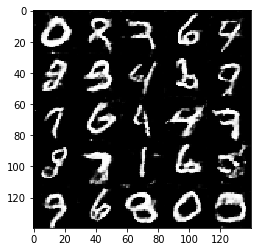

Epoch 2/2:	 Discriminator loss: 1.117	 Generator loss: 0.862
Epoch 2/2:	 Discriminator loss: 0.494	 Generator loss: 2.744
Epoch 2/2:	 Discriminator loss: 0.913	 Generator loss: 0.842
Epoch 2/2:	 Discriminator loss: 0.765	 Generator loss: 2.222
Epoch 2/2:	 Discriminator loss: 0.939	 Generator loss: 1.315
Epoch 2/2:	 Discriminator loss: 0.462	 Generator loss: 1.855
Epoch 2/2:	 Discriminator loss: 0.602	 Generator loss: 3.413
Epoch 2/2:	 Discriminator loss: 0.600	 Generator loss: 2.081
Epoch 2/2:	 Discriminator loss: 1.142	 Generator loss: 4.508
Epoch 2/2:	 Discriminator loss: 0.578	 Generator loss: 2.932


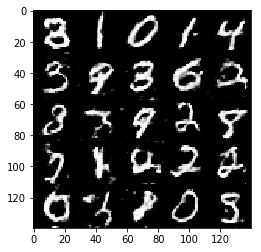

Epoch 2/2:	 Discriminator loss: 0.564	 Generator loss: 2.736
Epoch 2/2:	 Discriminator loss: 0.735	 Generator loss: 1.498
Epoch 2/2:	 Discriminator loss: 1.096	 Generator loss: 1.347
Epoch 2/2:	 Discriminator loss: 0.867	 Generator loss: 0.885
Epoch 2/2:	 Discriminator loss: 0.678	 Generator loss: 2.549
Epoch 2/2:	 Discriminator loss: 0.938	 Generator loss: 1.565
Epoch 2/2:	 Discriminator loss: 0.688	 Generator loss: 3.486
Epoch 2/2:	 Discriminator loss: 1.739	 Generator loss: 0.265
Epoch 2/2:	 Discriminator loss: 0.699	 Generator loss: 2.166
Epoch 2/2:	 Discriminator loss: 1.287	 Generator loss: 1.923


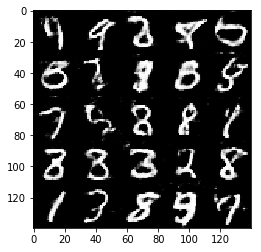

Epoch 2/2:	 Discriminator loss: 0.903	 Generator loss: 1.899
Epoch 2/2:	 Discriminator loss: 0.546	 Generator loss: 1.668
Epoch 2/2:	 Discriminator loss: 0.734	 Generator loss: 0.956
Epoch 2/2:	 Discriminator loss: 0.716	 Generator loss: 1.954
Epoch 2/2:	 Discriminator loss: 0.627	 Generator loss: 2.441
Epoch 2/2:	 Discriminator loss: 1.183	 Generator loss: 1.549
Epoch 2/2:	 Discriminator loss: 0.582	 Generator loss: 3.144
Epoch 2/2:	 Discriminator loss: 0.617	 Generator loss: 2.620
Epoch 2/2:	 Discriminator loss: 0.553	 Generator loss: 2.440
Epoch 2/2:	 Discriminator loss: 0.932	 Generator loss: 1.601


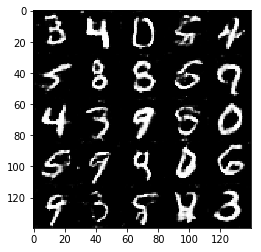

Epoch 2/2:	 Discriminator loss: 0.644	 Generator loss: 1.654
Epoch 2/2:	 Discriminator loss: 0.852	 Generator loss: 2.594
Epoch 2/2:	 Discriminator loss: 0.622	 Generator loss: 1.167
Epoch 2/2:	 Discriminator loss: 1.572	 Generator loss: 0.939
Epoch 2/2:	 Discriminator loss: 0.671	 Generator loss: 0.879
Epoch 2/2:	 Discriminator loss: 1.057	 Generator loss: 3.937
Epoch 2/2:	 Discriminator loss: 0.713	 Generator loss: 2.741
Epoch 2/2:	 Discriminator loss: 0.608	 Generator loss: 1.846
Epoch 2/2:	 Discriminator loss: 0.580	 Generator loss: 2.793
Epoch 2/2:	 Discriminator loss: 0.614	 Generator loss: 1.974


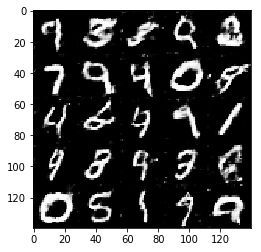

Epoch 2/2:	 Discriminator loss: 1.073	 Generator loss: 0.462
Epoch 2/2:	 Discriminator loss: 1.003	 Generator loss: 2.400
Epoch 2/2:	 Discriminator loss: 0.661	 Generator loss: 3.198
Epoch 2/2:	 Discriminator loss: 0.937	 Generator loss: 1.156
Epoch 2/2:	 Discriminator loss: 0.575	 Generator loss: 1.773
Epoch 2/2:	 Discriminator loss: 0.750	 Generator loss: 1.501
Epoch 2/2:	 Discriminator loss: 0.971	 Generator loss: 1.757
Epoch 2/2:	 Discriminator loss: 1.164	 Generator loss: 0.638
Epoch 2/2:	 Discriminator loss: 0.840	 Generator loss: 1.602
Epoch 2/2:	 Discriminator loss: 0.502	 Generator loss: 2.037


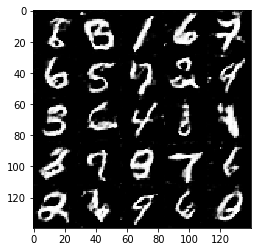

Epoch 2/2:	 Discriminator loss: 0.605	 Generator loss: 1.371
Epoch 2/2:	 Discriminator loss: 0.827	 Generator loss: 0.604
Epoch 2/2:	 Discriminator loss: 0.785	 Generator loss: 2.593
Epoch 2/2:	 Discriminator loss: 1.082	 Generator loss: 2.039
Epoch 2/2:	 Discriminator loss: 0.910	 Generator loss: 3.004
Epoch 2/2:	 Discriminator loss: 0.967	 Generator loss: 4.324
Epoch 2/2:	 Discriminator loss: 0.447	 Generator loss: 2.118
Epoch 2/2:	 Discriminator loss: 1.127	 Generator loss: 1.067
Epoch 2/2:	 Discriminator loss: 0.607	 Generator loss: 1.286
Epoch 2/2:	 Discriminator loss: 0.840	 Generator loss: 1.202


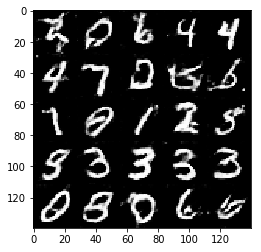

Epoch 2/2:	 Discriminator loss: 0.718	 Generator loss: 1.058
Epoch 2/2:	 Discriminator loss: 0.468	 Generator loss: 2.964
Epoch 2/2:	 Discriminator loss: 0.813	 Generator loss: 1.974
Epoch 2/2:	 Discriminator loss: 0.541	 Generator loss: 2.612
Epoch 2/2:	 Discriminator loss: 0.589	 Generator loss: 3.424
Epoch 2/2:	 Discriminator loss: 0.724	 Generator loss: 1.926
Epoch 2/2:	 Discriminator loss: 0.619	 Generator loss: 2.348
Epoch 2/2:	 Discriminator loss: 1.362	 Generator loss: 1.334
Epoch 2/2:	 Discriminator loss: 0.830	 Generator loss: 0.981
Epoch 2/2:	 Discriminator loss: 0.456	 Generator loss: 2.704


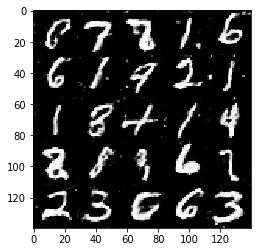

Epoch 2/2:	 Discriminator loss: 0.463	 Generator loss: 2.785
Epoch 2/2:	 Discriminator loss: 0.986	 Generator loss: 2.086
Epoch 2/2:	 Discriminator loss: 0.826	 Generator loss: 1.308
Epoch 2/2:	 Discriminator loss: 0.673	 Generator loss: 1.087
Epoch 2/2:	 Discriminator loss: 0.509	 Generator loss: 1.561
Epoch 2/2:	 Discriminator loss: 0.623	 Generator loss: 1.505
Epoch 2/2:	 Discriminator loss: 0.677	 Generator loss: 1.551
Epoch 2/2:	 Discriminator loss: 0.778	 Generator loss: 4.624
Epoch 2/2:	 Discriminator loss: 0.554	 Generator loss: 2.230
Epoch 2/2:	 Discriminator loss: 0.708	 Generator loss: 3.221


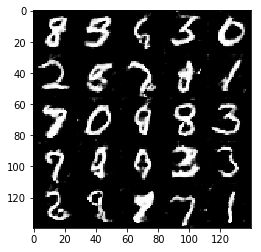

Epoch 2/2:	 Discriminator loss: 0.648	 Generator loss: 2.488
Epoch 2/2:	 Discriminator loss: 0.572	 Generator loss: 3.491
Epoch 2/2:	 Discriminator loss: 0.719	 Generator loss: 3.013
Epoch 2/2:	 Discriminator loss: 0.515	 Generator loss: 1.967
Epoch 2/2:	 Discriminator loss: 0.605	 Generator loss: 4.067
Epoch 2/2:	 Discriminator loss: 0.761	 Generator loss: 3.064
Epoch 2/2:	 Discriminator loss: 0.666	 Generator loss: 1.652
Epoch 2/2:	 Discriminator loss: 0.573	 Generator loss: 2.216
Epoch 2/2:	 Discriminator loss: 0.767	 Generator loss: 1.021
Epoch 2/2:	 Discriminator loss: 0.613	 Generator loss: 2.508


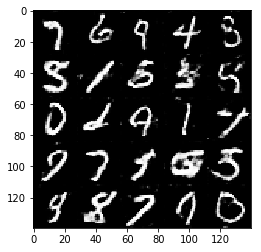

Epoch 2/2:	 Discriminator loss: 1.157	 Generator loss: 0.317
Epoch 2/2:	 Discriminator loss: 1.233	 Generator loss: 0.786
Epoch 2/2:	 Discriminator loss: 0.652	 Generator loss: 4.047
Epoch 2/2:	 Discriminator loss: 0.501	 Generator loss: 2.320
Epoch 2/2:	 Discriminator loss: 0.686	 Generator loss: 2.812
Epoch 2/2:	 Discriminator loss: 1.381	 Generator loss: 0.675
Epoch 2/2:	 Discriminator loss: 0.522	 Generator loss: 3.021
Epoch 2/2:	 Discriminator loss: 0.749	 Generator loss: 1.340
Epoch 2/2:	 Discriminator loss: 1.734	 Generator loss: 0.956
Epoch 2/2:	 Discriminator loss: 0.538	 Generator loss: 1.933


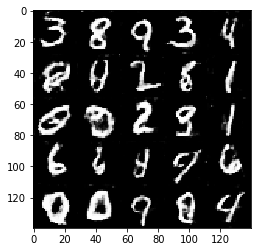

Epoch 2/2:	 Discriminator loss: 0.707	 Generator loss: 1.671
Epoch 2/2:	 Discriminator loss: 0.513	 Generator loss: 2.319
Epoch 2/2:	 Discriminator loss: 0.663	 Generator loss: 2.053
Epoch 2/2:	 Discriminator loss: 0.845	 Generator loss: 2.481
Epoch 2/2:	 Discriminator loss: 0.437	 Generator loss: 2.474


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1:	 Discriminator loss: 0.542	 Generator loss: 3.192
Epoch 1/1:	 Discriminator loss: 3.109	 Generator loss: 7.776
Epoch 1/1:	 Discriminator loss: 2.463	 Generator loss: 0.187
Epoch 1/1:	 Discriminator loss: 1.422	 Generator loss: 1.497
Epoch 1/1:	 Discriminator loss: 1.455	 Generator loss: 4.592
Epoch 1/1:	 Discriminator loss: 0.753	 Generator loss: 1.876
Epoch 1/1:	 Discriminator loss: 0.619	 Generator loss: 1.565
Epoch 1/1:	 Discriminator loss: 0.823	 Generator loss: 1.848
Epoch 1/1:	 Discriminator loss: 1.158	 Generator loss: 1.001
Epoch 1/1:	 Discriminator loss: 1.147	 Generator loss: 0.935


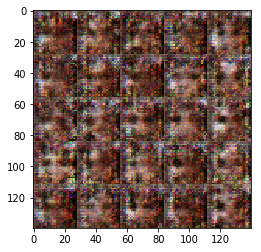

Epoch 1/1:	 Discriminator loss: 1.250	 Generator loss: 1.023
Epoch 1/1:	 Discriminator loss: 1.790	 Generator loss: 0.679
Epoch 1/1:	 Discriminator loss: 0.992	 Generator loss: 1.459
Epoch 1/1:	 Discriminator loss: 1.159	 Generator loss: 0.894
Epoch 1/1:	 Discriminator loss: 1.244	 Generator loss: 1.267
Epoch 1/1:	 Discriminator loss: 1.593	 Generator loss: 0.461
Epoch 1/1:	 Discriminator loss: 1.146	 Generator loss: 1.087
Epoch 1/1:	 Discriminator loss: 0.985	 Generator loss: 1.470
Epoch 1/1:	 Discriminator loss: 1.563	 Generator loss: 0.474
Epoch 1/1:	 Discriminator loss: 1.356	 Generator loss: 0.823


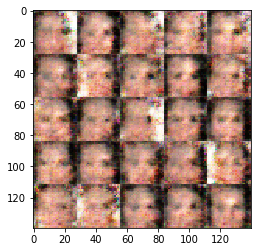

Epoch 1/1:	 Discriminator loss: 1.123	 Generator loss: 1.383
Epoch 1/1:	 Discriminator loss: 1.194	 Generator loss: 1.076
Epoch 1/1:	 Discriminator loss: 1.036	 Generator loss: 1.391
Epoch 1/1:	 Discriminator loss: 1.119	 Generator loss: 1.476
Epoch 1/1:	 Discriminator loss: 1.378	 Generator loss: 0.880
Epoch 1/1:	 Discriminator loss: 1.025	 Generator loss: 1.062
Epoch 1/1:	 Discriminator loss: 1.089	 Generator loss: 0.725
Epoch 1/1:	 Discriminator loss: 1.221	 Generator loss: 1.234
Epoch 1/1:	 Discriminator loss: 1.277	 Generator loss: 0.587
Epoch 1/1:	 Discriminator loss: 1.251	 Generator loss: 0.853


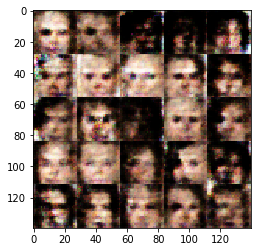

Epoch 1/1:	 Discriminator loss: 1.397	 Generator loss: 1.616
Epoch 1/1:	 Discriminator loss: 1.442	 Generator loss: 1.558
Epoch 1/1:	 Discriminator loss: 1.315	 Generator loss: 1.002
Epoch 1/1:	 Discriminator loss: 1.013	 Generator loss: 1.127
Epoch 1/1:	 Discriminator loss: 1.553	 Generator loss: 0.637
Epoch 1/1:	 Discriminator loss: 1.142	 Generator loss: 1.304
Epoch 1/1:	 Discriminator loss: 1.154	 Generator loss: 1.199
Epoch 1/1:	 Discriminator loss: 1.457	 Generator loss: 1.724
Epoch 1/1:	 Discriminator loss: 1.707	 Generator loss: 0.622
Epoch 1/1:	 Discriminator loss: 1.179	 Generator loss: 0.862


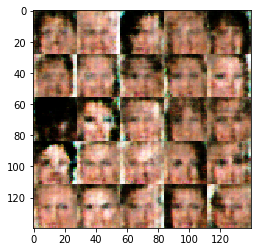

Epoch 1/1:	 Discriminator loss: 1.534	 Generator loss: 0.990
Epoch 1/1:	 Discriminator loss: 1.186	 Generator loss: 1.300
Epoch 1/1:	 Discriminator loss: 1.093	 Generator loss: 0.939
Epoch 1/1:	 Discriminator loss: 1.134	 Generator loss: 1.342
Epoch 1/1:	 Discriminator loss: 0.962	 Generator loss: 1.678
Epoch 1/1:	 Discriminator loss: 1.359	 Generator loss: 1.088
Epoch 1/1:	 Discriminator loss: 1.260	 Generator loss: 0.490
Epoch 1/1:	 Discriminator loss: 1.283	 Generator loss: 0.672
Epoch 1/1:	 Discriminator loss: 1.080	 Generator loss: 0.505
Epoch 1/1:	 Discriminator loss: 1.757	 Generator loss: 0.357


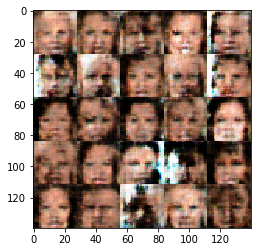

Epoch 1/1:	 Discriminator loss: 1.183	 Generator loss: 1.429
Epoch 1/1:	 Discriminator loss: 1.248	 Generator loss: 0.688
Epoch 1/1:	 Discriminator loss: 1.181	 Generator loss: 0.795
Epoch 1/1:	 Discriminator loss: 1.420	 Generator loss: 0.657
Epoch 1/1:	 Discriminator loss: 1.087	 Generator loss: 0.984
Epoch 1/1:	 Discriminator loss: 1.096	 Generator loss: 1.235
Epoch 1/1:	 Discriminator loss: 1.086	 Generator loss: 0.917
Epoch 1/1:	 Discriminator loss: 2.089	 Generator loss: 3.405
Epoch 1/1:	 Discriminator loss: 1.556	 Generator loss: 0.552
Epoch 1/1:	 Discriminator loss: 1.120	 Generator loss: 1.149


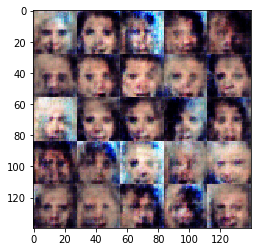

Epoch 1/1:	 Discriminator loss: 1.158	 Generator loss: 0.700
Epoch 1/1:	 Discriminator loss: 1.285	 Generator loss: 1.176
Epoch 1/1:	 Discriminator loss: 1.234	 Generator loss: 1.108
Epoch 1/1:	 Discriminator loss: 1.221	 Generator loss: 0.626
Epoch 1/1:	 Discriminator loss: 1.121	 Generator loss: 1.181
Epoch 1/1:	 Discriminator loss: 0.950	 Generator loss: 0.839
Epoch 1/1:	 Discriminator loss: 1.005	 Generator loss: 0.827
Epoch 1/1:	 Discriminator loss: 1.166	 Generator loss: 1.167
Epoch 1/1:	 Discriminator loss: 1.311	 Generator loss: 0.490
Epoch 1/1:	 Discriminator loss: 1.182	 Generator loss: 1.183


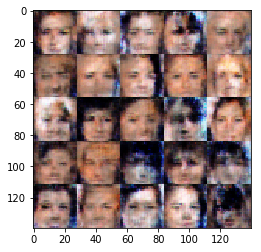

Epoch 1/1:	 Discriminator loss: 0.873	 Generator loss: 1.865
Epoch 1/1:	 Discriminator loss: 1.362	 Generator loss: 2.034
Epoch 1/1:	 Discriminator loss: 1.188	 Generator loss: 1.245
Epoch 1/1:	 Discriminator loss: 0.992	 Generator loss: 0.842
Epoch 1/1:	 Discriminator loss: 1.210	 Generator loss: 0.653
Epoch 1/1:	 Discriminator loss: 0.987	 Generator loss: 1.331
Epoch 1/1:	 Discriminator loss: 1.002	 Generator loss: 1.056
Epoch 1/1:	 Discriminator loss: 1.158	 Generator loss: 1.646
Epoch 1/1:	 Discriminator loss: 1.386	 Generator loss: 0.419
Epoch 1/1:	 Discriminator loss: 1.162	 Generator loss: 1.497


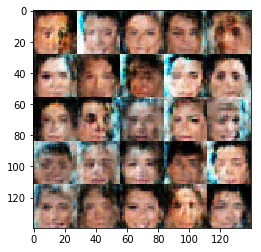

Epoch 1/1:	 Discriminator loss: 1.043	 Generator loss: 0.769
Epoch 1/1:	 Discriminator loss: 1.178	 Generator loss: 0.912
Epoch 1/1:	 Discriminator loss: 1.445	 Generator loss: 0.570
Epoch 1/1:	 Discriminator loss: 0.887	 Generator loss: 1.692
Epoch 1/1:	 Discriminator loss: 1.041	 Generator loss: 0.683
Epoch 1/1:	 Discriminator loss: 1.239	 Generator loss: 0.909
Epoch 1/1:	 Discriminator loss: 1.102	 Generator loss: 0.749
Epoch 1/1:	 Discriminator loss: 0.989	 Generator loss: 0.926
Epoch 1/1:	 Discriminator loss: 1.175	 Generator loss: 0.933
Epoch 1/1:	 Discriminator loss: 0.918	 Generator loss: 0.759


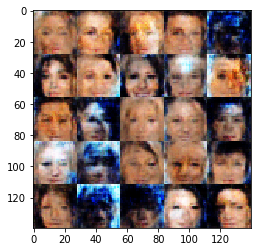

Epoch 1/1:	 Discriminator loss: 1.016	 Generator loss: 1.205
Epoch 1/1:	 Discriminator loss: 1.353	 Generator loss: 0.554
Epoch 1/1:	 Discriminator loss: 1.133	 Generator loss: 0.638
Epoch 1/1:	 Discriminator loss: 1.555	 Generator loss: 0.510
Epoch 1/1:	 Discriminator loss: 1.127	 Generator loss: 0.670
Epoch 1/1:	 Discriminator loss: 0.881	 Generator loss: 2.488
Epoch 1/1:	 Discriminator loss: 1.090	 Generator loss: 1.564
Epoch 1/1:	 Discriminator loss: 0.877	 Generator loss: 1.536
Epoch 1/1:	 Discriminator loss: 1.314	 Generator loss: 0.788
Epoch 1/1:	 Discriminator loss: 1.056	 Generator loss: 0.651


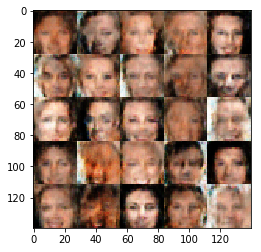

Epoch 1/1:	 Discriminator loss: 1.298	 Generator loss: 0.389
Epoch 1/1:	 Discriminator loss: 1.415	 Generator loss: 2.305
Epoch 1/1:	 Discriminator loss: 1.130	 Generator loss: 1.133
Epoch 1/1:	 Discriminator loss: 1.093	 Generator loss: 1.197
Epoch 1/1:	 Discriminator loss: 0.969	 Generator loss: 1.098
Epoch 1/1:	 Discriminator loss: 0.998	 Generator loss: 1.307
Epoch 1/1:	 Discriminator loss: 0.906	 Generator loss: 1.734
Epoch 1/1:	 Discriminator loss: 1.129	 Generator loss: 2.315
Epoch 1/1:	 Discriminator loss: 1.513	 Generator loss: 1.533
Epoch 1/1:	 Discriminator loss: 0.994	 Generator loss: 1.872


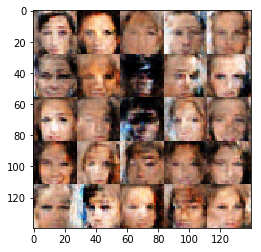

Epoch 1/1:	 Discriminator loss: 1.200	 Generator loss: 1.949
Epoch 1/1:	 Discriminator loss: 1.347	 Generator loss: 0.425
Epoch 1/1:	 Discriminator loss: 1.174	 Generator loss: 0.517
Epoch 1/1:	 Discriminator loss: 1.070	 Generator loss: 0.857
Epoch 1/1:	 Discriminator loss: 1.127	 Generator loss: 1.147
Epoch 1/1:	 Discriminator loss: 2.128	 Generator loss: 2.910
Epoch 1/1:	 Discriminator loss: 1.188	 Generator loss: 0.772
Epoch 1/1:	 Discriminator loss: 1.055	 Generator loss: 0.703
Epoch 1/1:	 Discriminator loss: 1.073	 Generator loss: 1.421
Epoch 1/1:	 Discriminator loss: 1.135	 Generator loss: 0.678


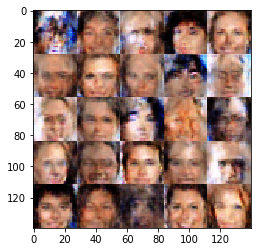

Epoch 1/1:	 Discriminator loss: 1.291	 Generator loss: 0.744
Epoch 1/1:	 Discriminator loss: 1.639	 Generator loss: 2.598
Epoch 1/1:	 Discriminator loss: 0.974	 Generator loss: 1.139
Epoch 1/1:	 Discriminator loss: 1.056	 Generator loss: 1.472
Epoch 1/1:	 Discriminator loss: 0.991	 Generator loss: 1.883
Epoch 1/1:	 Discriminator loss: 1.026	 Generator loss: 1.121
Epoch 1/1:	 Discriminator loss: 1.102	 Generator loss: 0.674
Epoch 1/1:	 Discriminator loss: 1.013	 Generator loss: 1.861
Epoch 1/1:	 Discriminator loss: 1.683	 Generator loss: 0.568
Epoch 1/1:	 Discriminator loss: 1.247	 Generator loss: 0.581


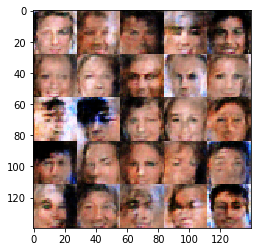

Epoch 1/1:	 Discriminator loss: 1.045	 Generator loss: 0.961
Epoch 1/1:	 Discriminator loss: 1.362	 Generator loss: 1.986
Epoch 1/1:	 Discriminator loss: 1.284	 Generator loss: 1.517
Epoch 1/1:	 Discriminator loss: 0.982	 Generator loss: 1.019
Epoch 1/1:	 Discriminator loss: 1.007	 Generator loss: 1.722
Epoch 1/1:	 Discriminator loss: 0.980	 Generator loss: 1.139
Epoch 1/1:	 Discriminator loss: 1.081	 Generator loss: 1.484
Epoch 1/1:	 Discriminator loss: 0.973	 Generator loss: 1.932
Epoch 1/1:	 Discriminator loss: 1.340	 Generator loss: 1.930
Epoch 1/1:	 Discriminator loss: 1.602	 Generator loss: 0.563


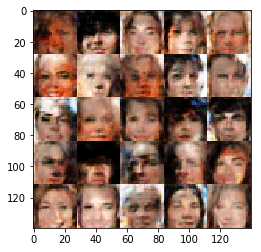

Epoch 1/1:	 Discriminator loss: 0.821	 Generator loss: 0.846
Epoch 1/1:	 Discriminator loss: 1.244	 Generator loss: 0.484
Epoch 1/1:	 Discriminator loss: 1.102	 Generator loss: 1.897
Epoch 1/1:	 Discriminator loss: 1.263	 Generator loss: 2.285
Epoch 1/1:	 Discriminator loss: 0.759	 Generator loss: 1.329
Epoch 1/1:	 Discriminator loss: 1.019	 Generator loss: 0.786
Epoch 1/1:	 Discriminator loss: 0.955	 Generator loss: 0.970
Epoch 1/1:	 Discriminator loss: 0.966	 Generator loss: 0.595
Epoch 1/1:	 Discriminator loss: 0.898	 Generator loss: 1.650
Epoch 1/1:	 Discriminator loss: 1.030	 Generator loss: 0.765


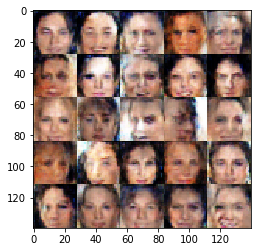

Epoch 1/1:	 Discriminator loss: 0.826	 Generator loss: 1.262
Epoch 1/1:	 Discriminator loss: 1.105	 Generator loss: 1.387
Epoch 1/1:	 Discriminator loss: 0.891	 Generator loss: 1.445
Epoch 1/1:	 Discriminator loss: 1.400	 Generator loss: 0.696
Epoch 1/1:	 Discriminator loss: 0.825	 Generator loss: 1.151
Epoch 1/1:	 Discriminator loss: 0.996	 Generator loss: 1.417
Epoch 1/1:	 Discriminator loss: 0.877	 Generator loss: 1.233
Epoch 1/1:	 Discriminator loss: 1.165	 Generator loss: 1.062
Epoch 1/1:	 Discriminator loss: 0.943	 Generator loss: 0.774
Epoch 1/1:	 Discriminator loss: 1.046	 Generator loss: 1.046


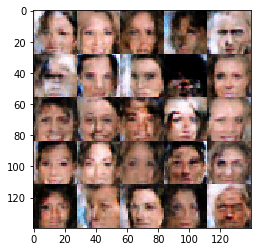

Epoch 1/1:	 Discriminator loss: 0.885	 Generator loss: 1.533
Epoch 1/1:	 Discriminator loss: 1.294	 Generator loss: 1.270
Epoch 1/1:	 Discriminator loss: 1.509	 Generator loss: 0.261
Epoch 1/1:	 Discriminator loss: 1.442	 Generator loss: 0.341
Epoch 1/1:	 Discriminator loss: 1.224	 Generator loss: 0.777
Epoch 1/1:	 Discriminator loss: 1.227	 Generator loss: 0.792
Epoch 1/1:	 Discriminator loss: 1.187	 Generator loss: 0.862
Epoch 1/1:	 Discriminator loss: 1.151	 Generator loss: 0.991
Epoch 1/1:	 Discriminator loss: 0.845	 Generator loss: 1.658
Epoch 1/1:	 Discriminator loss: 0.812	 Generator loss: 1.017


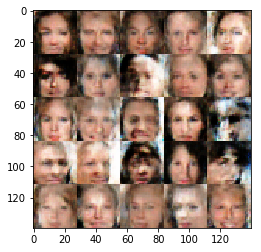

Epoch 1/1:	 Discriminator loss: 1.617	 Generator loss: 0.521
Epoch 1/1:	 Discriminator loss: 0.818	 Generator loss: 1.553
Epoch 1/1:	 Discriminator loss: 1.373	 Generator loss: 0.703
Epoch 1/1:	 Discriminator loss: 0.939	 Generator loss: 1.658
Epoch 1/1:	 Discriminator loss: 0.899	 Generator loss: 1.129
Epoch 1/1:	 Discriminator loss: 0.948	 Generator loss: 0.561
Epoch 1/1:	 Discriminator loss: 0.891	 Generator loss: 1.074
Epoch 1/1:	 Discriminator loss: 0.852	 Generator loss: 0.780
Epoch 1/1:	 Discriminator loss: 1.026	 Generator loss: 2.052
Epoch 1/1:	 Discriminator loss: 1.164	 Generator loss: 0.758


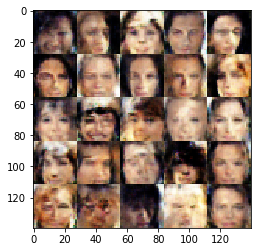

Epoch 1/1:	 Discriminator loss: 1.010	 Generator loss: 0.896
Epoch 1/1:	 Discriminator loss: 1.284	 Generator loss: 0.974
Epoch 1/1:	 Discriminator loss: 1.019	 Generator loss: 1.119
Epoch 1/1:	 Discriminator loss: 1.009	 Generator loss: 0.800
Epoch 1/1:	 Discriminator loss: 0.919	 Generator loss: 1.384
Epoch 1/1:	 Discriminator loss: 1.029	 Generator loss: 1.174
Epoch 1/1:	 Discriminator loss: 1.243	 Generator loss: 0.776
Epoch 1/1:	 Discriminator loss: 1.062	 Generator loss: 0.893
Epoch 1/1:	 Discriminator loss: 0.980	 Generator loss: 1.264
Epoch 1/1:	 Discriminator loss: 1.120	 Generator loss: 0.957


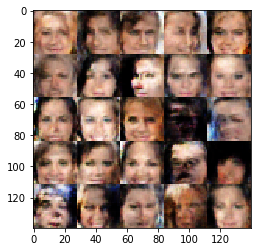

Epoch 1/1:	 Discriminator loss: 1.147	 Generator loss: 0.928
Epoch 1/1:	 Discriminator loss: 1.177	 Generator loss: 1.738
Epoch 1/1:	 Discriminator loss: 1.136	 Generator loss: 1.825
Epoch 1/1:	 Discriminator loss: 1.216	 Generator loss: 0.941
Epoch 1/1:	 Discriminator loss: 1.316	 Generator loss: 2.135
Epoch 1/1:	 Discriminator loss: 0.993	 Generator loss: 1.196
Epoch 1/1:	 Discriminator loss: 0.948	 Generator loss: 1.905
Epoch 1/1:	 Discriminator loss: 1.125	 Generator loss: 0.959
Epoch 1/1:	 Discriminator loss: 1.566	 Generator loss: 0.460
Epoch 1/1:	 Discriminator loss: 0.889	 Generator loss: 1.608


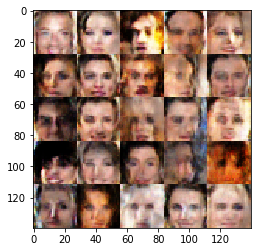

Epoch 1/1:	 Discriminator loss: 1.454	 Generator loss: 3.422
Epoch 1/1:	 Discriminator loss: 1.240	 Generator loss: 0.375
Epoch 1/1:	 Discriminator loss: 0.913	 Generator loss: 1.311
Epoch 1/1:	 Discriminator loss: 0.715	 Generator loss: 1.750
Epoch 1/1:	 Discriminator loss: 1.129	 Generator loss: 0.760
Epoch 1/1:	 Discriminator loss: 1.192	 Generator loss: 0.680
Epoch 1/1:	 Discriminator loss: 1.040	 Generator loss: 1.758
Epoch 1/1:	 Discriminator loss: 0.838	 Generator loss: 1.498
Epoch 1/1:	 Discriminator loss: 1.258	 Generator loss: 0.935
Epoch 1/1:	 Discriminator loss: 1.329	 Generator loss: 0.897


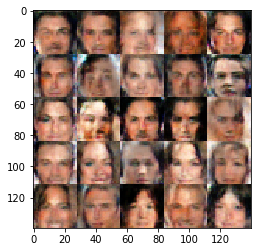

Epoch 1/1:	 Discriminator loss: 0.977	 Generator loss: 0.701
Epoch 1/1:	 Discriminator loss: 1.485	 Generator loss: 0.408
Epoch 1/1:	 Discriminator loss: 0.973	 Generator loss: 0.649
Epoch 1/1:	 Discriminator loss: 1.242	 Generator loss: 0.425
Epoch 1/1:	 Discriminator loss: 1.010	 Generator loss: 2.400
Epoch 1/1:	 Discriminator loss: 0.955	 Generator loss: 2.037
Epoch 1/1:	 Discriminator loss: 0.903	 Generator loss: 1.625
Epoch 1/1:	 Discriminator loss: 1.320	 Generator loss: 0.670
Epoch 1/1:	 Discriminator loss: 0.799	 Generator loss: 1.206
Epoch 1/1:	 Discriminator loss: 1.390	 Generator loss: 3.148


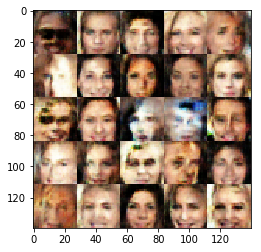

Epoch 1/1:	 Discriminator loss: 0.785	 Generator loss: 0.917
Epoch 1/1:	 Discriminator loss: 0.799	 Generator loss: 1.298
Epoch 1/1:	 Discriminator loss: 0.783	 Generator loss: 1.216
Epoch 1/1:	 Discriminator loss: 0.996	 Generator loss: 0.439
Epoch 1/1:	 Discriminator loss: 1.318	 Generator loss: 1.686
Epoch 1/1:	 Discriminator loss: 1.243	 Generator loss: 0.583
Epoch 1/1:	 Discriminator loss: 0.894	 Generator loss: 1.147
Epoch 1/1:	 Discriminator loss: 0.859	 Generator loss: 1.949
Epoch 1/1:	 Discriminator loss: 0.897	 Generator loss: 1.723
Epoch 1/1:	 Discriminator loss: 1.165	 Generator loss: 1.134


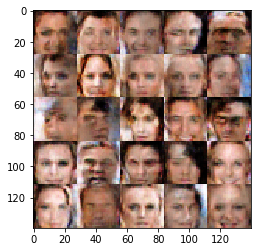

Epoch 1/1:	 Discriminator loss: 0.729	 Generator loss: 1.471
Epoch 1/1:	 Discriminator loss: 1.167	 Generator loss: 1.203
Epoch 1/1:	 Discriminator loss: 1.273	 Generator loss: 2.362
Epoch 1/1:	 Discriminator loss: 0.935	 Generator loss: 2.001
Epoch 1/1:	 Discriminator loss: 1.258	 Generator loss: 4.131
Epoch 1/1:	 Discriminator loss: 0.784	 Generator loss: 1.357
Epoch 1/1:	 Discriminator loss: 0.760	 Generator loss: 1.420
Epoch 1/1:	 Discriminator loss: 2.451	 Generator loss: 4.394
Epoch 1/1:	 Discriminator loss: 1.302	 Generator loss: 0.329
Epoch 1/1:	 Discriminator loss: 0.792	 Generator loss: 1.705


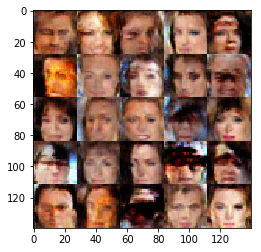

Epoch 1/1:	 Discriminator loss: 1.006	 Generator loss: 1.255
Epoch 1/1:	 Discriminator loss: 0.862	 Generator loss: 0.874
Epoch 1/1:	 Discriminator loss: 1.519	 Generator loss: 0.490
Epoch 1/1:	 Discriminator loss: 1.030	 Generator loss: 0.743
Epoch 1/1:	 Discriminator loss: 1.060	 Generator loss: 1.145
Epoch 1/1:	 Discriminator loss: 0.918	 Generator loss: 1.271
Epoch 1/1:	 Discriminator loss: 0.955	 Generator loss: 0.759
Epoch 1/1:	 Discriminator loss: 1.158	 Generator loss: 3.118
Epoch 1/1:	 Discriminator loss: 1.152	 Generator loss: 2.655
Epoch 1/1:	 Discriminator loss: 0.948	 Generator loss: 2.224


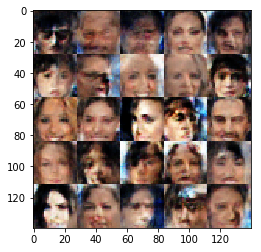

Epoch 1/1:	 Discriminator loss: 0.569	 Generator loss: 1.640
Epoch 1/1:	 Discriminator loss: 0.846	 Generator loss: 1.313
Epoch 1/1:	 Discriminator loss: 1.404	 Generator loss: 0.463
Epoch 1/1:	 Discriminator loss: 0.884	 Generator loss: 1.065
Epoch 1/1:	 Discriminator loss: 0.997	 Generator loss: 1.054
Epoch 1/1:	 Discriminator loss: 0.946	 Generator loss: 0.684
Epoch 1/1:	 Discriminator loss: 0.911	 Generator loss: 0.725
Epoch 1/1:	 Discriminator loss: 0.850	 Generator loss: 0.763
Epoch 1/1:	 Discriminator loss: 1.382	 Generator loss: 0.549
Epoch 1/1:	 Discriminator loss: 1.508	 Generator loss: 0.470


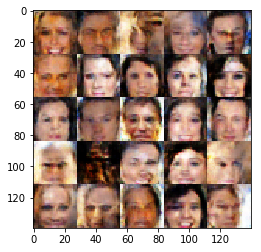

Epoch 1/1:	 Discriminator loss: 0.585	 Generator loss: 1.651
Epoch 1/1:	 Discriminator loss: 1.247	 Generator loss: 0.694
Epoch 1/1:	 Discriminator loss: 0.946	 Generator loss: 1.548
Epoch 1/1:	 Discriminator loss: 0.874	 Generator loss: 1.708
Epoch 1/1:	 Discriminator loss: 0.743	 Generator loss: 1.617
Epoch 1/1:	 Discriminator loss: 0.697	 Generator loss: 1.745
Epoch 1/1:	 Discriminator loss: 1.289	 Generator loss: 1.271
Epoch 1/1:	 Discriminator loss: 0.689	 Generator loss: 2.048
Epoch 1/1:	 Discriminator loss: 0.940	 Generator loss: 2.736
Epoch 1/1:	 Discriminator loss: 0.984	 Generator loss: 0.860


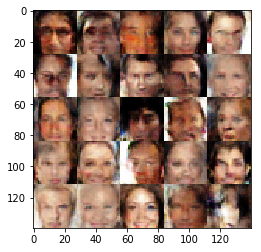

Epoch 1/1:	 Discriminator loss: 1.059	 Generator loss: 0.775
Epoch 1/1:	 Discriminator loss: 1.175	 Generator loss: 1.712
Epoch 1/1:	 Discriminator loss: 0.737	 Generator loss: 1.398
Epoch 1/1:	 Discriminator loss: 0.578	 Generator loss: 1.931
Epoch 1/1:	 Discriminator loss: 1.831	 Generator loss: 0.328
Epoch 1/1:	 Discriminator loss: 0.607	 Generator loss: 1.929
Epoch 1/1:	 Discriminator loss: 1.037	 Generator loss: 1.274
Epoch 1/1:	 Discriminator loss: 0.808	 Generator loss: 2.718
Epoch 1/1:	 Discriminator loss: 0.889	 Generator loss: 1.241
Epoch 1/1:	 Discriminator loss: 0.752	 Generator loss: 1.581


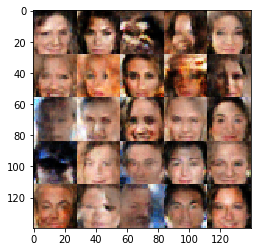

Epoch 1/1:	 Discriminator loss: 0.935	 Generator loss: 1.988
Epoch 1/1:	 Discriminator loss: 1.522	 Generator loss: 2.489
Epoch 1/1:	 Discriminator loss: 0.660	 Generator loss: 1.168
Epoch 1/1:	 Discriminator loss: 0.812	 Generator loss: 2.105
Epoch 1/1:	 Discriminator loss: 1.199	 Generator loss: 2.434
Epoch 1/1:	 Discriminator loss: 0.790	 Generator loss: 1.331
Epoch 1/1:	 Discriminator loss: 0.903	 Generator loss: 1.879
Epoch 1/1:	 Discriminator loss: 0.777	 Generator loss: 1.924
Epoch 1/1:	 Discriminator loss: 1.255	 Generator loss: 3.004
Epoch 1/1:	 Discriminator loss: 0.982	 Generator loss: 1.752


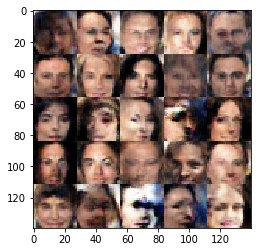

Epoch 1/1:	 Discriminator loss: 0.723	 Generator loss: 1.486
Epoch 1/1:	 Discriminator loss: 0.774	 Generator loss: 0.837
Epoch 1/1:	 Discriminator loss: 0.789	 Generator loss: 1.670
Epoch 1/1:	 Discriminator loss: 0.880	 Generator loss: 1.803
Epoch 1/1:	 Discriminator loss: 0.765	 Generator loss: 1.281
Epoch 1/1:	 Discriminator loss: 1.482	 Generator loss: 0.349
Epoch 1/1:	 Discriminator loss: 0.701	 Generator loss: 0.815
Epoch 1/1:	 Discriminator loss: 0.708	 Generator loss: 1.743
Epoch 1/1:	 Discriminator loss: 0.632	 Generator loss: 1.330
Epoch 1/1:	 Discriminator loss: 0.797	 Generator loss: 1.237


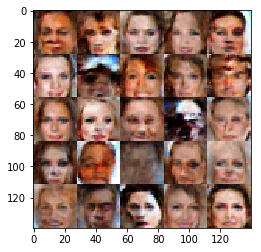

Epoch 1/1:	 Discriminator loss: 0.922	 Generator loss: 1.474
Epoch 1/1:	 Discriminator loss: 0.687	 Generator loss: 2.006
Epoch 1/1:	 Discriminator loss: 1.538	 Generator loss: 0.407
Epoch 1/1:	 Discriminator loss: 0.689	 Generator loss: 1.796
Epoch 1/1:	 Discriminator loss: 0.949	 Generator loss: 2.008
Epoch 1/1:	 Discriminator loss: 0.589	 Generator loss: 1.859
Epoch 1/1:	 Discriminator loss: 1.559	 Generator loss: 0.449
Epoch 1/1:	 Discriminator loss: 1.314	 Generator loss: 0.545
Epoch 1/1:	 Discriminator loss: 1.065	 Generator loss: 1.503
Epoch 1/1:	 Discriminator loss: 1.372	 Generator loss: 0.680


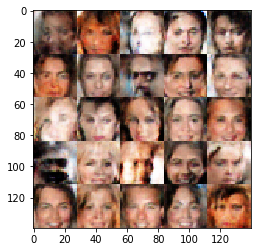

Epoch 1/1:	 Discriminator loss: 0.854	 Generator loss: 2.417
Epoch 1/1:	 Discriminator loss: 1.551	 Generator loss: 3.154
Epoch 1/1:	 Discriminator loss: 0.586	 Generator loss: 2.026
Epoch 1/1:	 Discriminator loss: 0.801	 Generator loss: 1.716
Epoch 1/1:	 Discriminator loss: 0.992	 Generator loss: 1.527
Epoch 1/1:	 Discriminator loss: 0.696	 Generator loss: 1.042
Epoch 1/1:	 Discriminator loss: 0.809	 Generator loss: 1.000
Epoch 1/1:	 Discriminator loss: 0.940	 Generator loss: 1.078
Epoch 1/1:	 Discriminator loss: 0.967	 Generator loss: 3.465
Epoch 1/1:	 Discriminator loss: 0.905	 Generator loss: 0.896


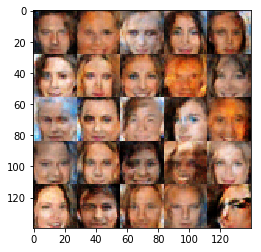

Epoch 1/1:	 Discriminator loss: 0.649	 Generator loss: 2.853
Epoch 1/1:	 Discriminator loss: 0.929	 Generator loss: 0.988
Epoch 1/1:	 Discriminator loss: 0.869	 Generator loss: 1.366
Epoch 1/1:	 Discriminator loss: 0.686	 Generator loss: 1.235
Epoch 1/1:	 Discriminator loss: 1.111	 Generator loss: 1.070
Epoch 1/1:	 Discriminator loss: 0.947	 Generator loss: 3.127
Epoch 1/1:	 Discriminator loss: 0.986	 Generator loss: 1.976
Epoch 1/1:	 Discriminator loss: 0.785	 Generator loss: 1.238
Epoch 1/1:	 Discriminator loss: 0.702	 Generator loss: 2.416
Epoch 1/1:	 Discriminator loss: 0.612	 Generator loss: 2.160


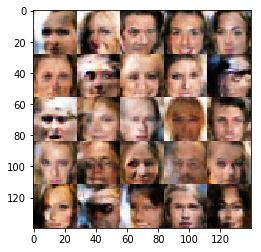

Epoch 1/1:	 Discriminator loss: 1.230	 Generator loss: 0.917
Epoch 1/1:	 Discriminator loss: 1.212	 Generator loss: 0.468
Epoch 1/1:	 Discriminator loss: 0.865	 Generator loss: 1.267
Epoch 1/1:	 Discriminator loss: 0.858	 Generator loss: 0.793
Epoch 1/1:	 Discriminator loss: 0.632	 Generator loss: 2.805
Epoch 1/1:	 Discriminator loss: 0.951	 Generator loss: 0.508
Epoch 1/1:	 Discriminator loss: 0.892	 Generator loss: 1.291
Epoch 1/1:	 Discriminator loss: 0.559	 Generator loss: 1.458
Epoch 1/1:	 Discriminator loss: 0.781	 Generator loss: 0.984
Epoch 1/1:	 Discriminator loss: 0.735	 Generator loss: 1.545


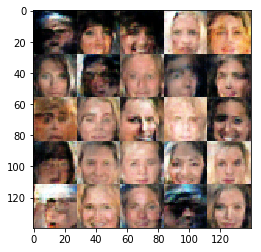

Epoch 1/1:	 Discriminator loss: 1.574	 Generator loss: 0.381
Epoch 1/1:	 Discriminator loss: 0.844	 Generator loss: 1.537
Epoch 1/1:	 Discriminator loss: 0.639	 Generator loss: 2.250
Epoch 1/1:	 Discriminator loss: 1.373	 Generator loss: 0.394
Epoch 1/1:	 Discriminator loss: 0.667	 Generator loss: 2.534
Epoch 1/1:	 Discriminator loss: 0.770	 Generator loss: 1.646
Epoch 1/1:	 Discriminator loss: 0.853	 Generator loss: 2.040
Epoch 1/1:	 Discriminator loss: 0.900	 Generator loss: 1.193
Epoch 1/1:	 Discriminator loss: 1.262	 Generator loss: 0.614
Epoch 1/1:	 Discriminator loss: 1.086	 Generator loss: 2.349


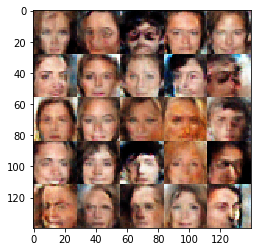

Epoch 1/1:	 Discriminator loss: 0.622	 Generator loss: 2.274
Epoch 1/1:	 Discriminator loss: 0.682	 Generator loss: 1.760
Epoch 1/1:	 Discriminator loss: 1.336	 Generator loss: 0.947
Epoch 1/1:	 Discriminator loss: 0.839	 Generator loss: 1.878
Epoch 1/1:	 Discriminator loss: 1.412	 Generator loss: 3.209
Epoch 1/1:	 Discriminator loss: 0.918	 Generator loss: 0.656
Epoch 1/1:	 Discriminator loss: 0.628	 Generator loss: 1.629
Epoch 1/1:	 Discriminator loss: 2.110	 Generator loss: 0.441
Epoch 1/1:	 Discriminator loss: 1.001	 Generator loss: 0.553
Epoch 1/1:	 Discriminator loss: 0.512	 Generator loss: 1.613


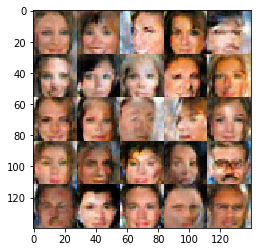

Epoch 1/1:	 Discriminator loss: 1.277	 Generator loss: 0.815
Epoch 1/1:	 Discriminator loss: 1.324	 Generator loss: 3.747
Epoch 1/1:	 Discriminator loss: 0.830	 Generator loss: 1.221
Epoch 1/1:	 Discriminator loss: 0.585	 Generator loss: 2.302
Epoch 1/1:	 Discriminator loss: 0.575	 Generator loss: 3.090
Epoch 1/1:	 Discriminator loss: 0.716	 Generator loss: 1.820
Epoch 1/1:	 Discriminator loss: 0.569	 Generator loss: 1.083
Epoch 1/1:	 Discriminator loss: 0.747	 Generator loss: 2.334
Epoch 1/1:	 Discriminator loss: 1.078	 Generator loss: 1.004
Epoch 1/1:	 Discriminator loss: 0.772	 Generator loss: 2.727


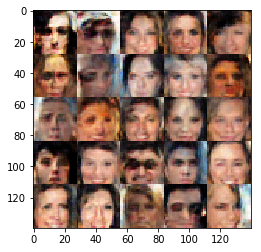

Epoch 1/1:	 Discriminator loss: 1.567	 Generator loss: 0.650
Epoch 1/1:	 Discriminator loss: 0.999	 Generator loss: 1.566
Epoch 1/1:	 Discriminator loss: 0.680	 Generator loss: 2.103
Epoch 1/1:	 Discriminator loss: 0.810	 Generator loss: 1.067
Epoch 1/1:	 Discriminator loss: 0.684	 Generator loss: 1.524
Epoch 1/1:	 Discriminator loss: 1.091	 Generator loss: 1.283
Epoch 1/1:	 Discriminator loss: 0.555	 Generator loss: 2.451
Epoch 1/1:	 Discriminator loss: 1.119	 Generator loss: 2.649
Epoch 1/1:	 Discriminator loss: 0.751	 Generator loss: 1.909
Epoch 1/1:	 Discriminator loss: 0.562	 Generator loss: 1.715


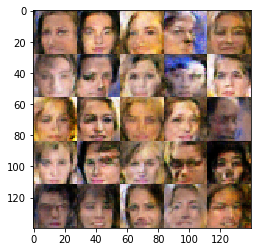

Epoch 1/1:	 Discriminator loss: 0.594	 Generator loss: 1.942
Epoch 1/1:	 Discriminator loss: 0.579	 Generator loss: 1.912
Epoch 1/1:	 Discriminator loss: 0.795	 Generator loss: 1.144
Epoch 1/1:	 Discriminator loss: 0.844	 Generator loss: 2.689
Epoch 1/1:	 Discriminator loss: 0.765	 Generator loss: 1.757
Epoch 1/1:	 Discriminator loss: 0.716	 Generator loss: 1.778
Epoch 1/1:	 Discriminator loss: 0.774	 Generator loss: 3.209
Epoch 1/1:	 Discriminator loss: 0.547	 Generator loss: 1.813
Epoch 1/1:	 Discriminator loss: 0.613	 Generator loss: 1.014
Epoch 1/1:	 Discriminator loss: 0.803	 Generator loss: 3.470


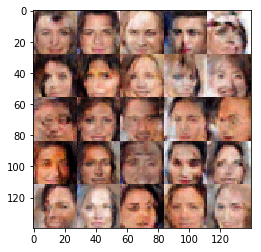

Epoch 1/1:	 Discriminator loss: 0.864	 Generator loss: 1.865
Epoch 1/1:	 Discriminator loss: 0.885	 Generator loss: 0.753
Epoch 1/1:	 Discriminator loss: 1.411	 Generator loss: 0.759
Epoch 1/1:	 Discriminator loss: 0.872	 Generator loss: 1.942
Epoch 1/1:	 Discriminator loss: 1.063	 Generator loss: 1.051
Epoch 1/1:	 Discriminator loss: 0.915	 Generator loss: 2.587
Epoch 1/1:	 Discriminator loss: 1.069	 Generator loss: 0.639
Epoch 1/1:	 Discriminator loss: 0.735	 Generator loss: 3.667
Epoch 1/1:	 Discriminator loss: 1.314	 Generator loss: 1.024
Epoch 1/1:	 Discriminator loss: 0.904	 Generator loss: 2.216


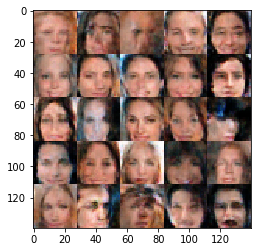

Epoch 1/1:	 Discriminator loss: 0.569	 Generator loss: 1.596
Epoch 1/1:	 Discriminator loss: 0.632	 Generator loss: 2.355
Epoch 1/1:	 Discriminator loss: 0.801	 Generator loss: 1.298
Epoch 1/1:	 Discriminator loss: 0.860	 Generator loss: 3.428
Epoch 1/1:	 Discriminator loss: 0.595	 Generator loss: 1.637
Epoch 1/1:	 Discriminator loss: 0.706	 Generator loss: 1.316
Epoch 1/1:	 Discriminator loss: 0.921	 Generator loss: 2.510
Epoch 1/1:	 Discriminator loss: 1.095	 Generator loss: 0.831
Epoch 1/1:	 Discriminator loss: 1.178	 Generator loss: 2.408
Epoch 1/1:	 Discriminator loss: 0.619	 Generator loss: 2.347


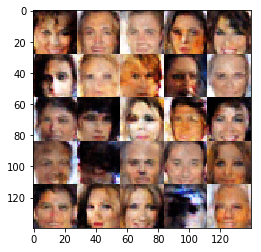

Epoch 1/1:	 Discriminator loss: 1.939	 Generator loss: 3.100
Epoch 1/1:	 Discriminator loss: 0.706	 Generator loss: 1.500
Epoch 1/1:	 Discriminator loss: 0.699	 Generator loss: 2.000
Epoch 1/1:	 Discriminator loss: 0.853	 Generator loss: 2.776
Epoch 1/1:	 Discriminator loss: 0.803	 Generator loss: 2.200
Epoch 1/1:	 Discriminator loss: 0.676	 Generator loss: 1.996
Epoch 1/1:	 Discriminator loss: 0.882	 Generator loss: 1.815
Epoch 1/1:	 Discriminator loss: 0.813	 Generator loss: 1.786
Epoch 1/1:	 Discriminator loss: 0.935	 Generator loss: 0.553
Epoch 1/1:	 Discriminator loss: 0.651	 Generator loss: 1.564


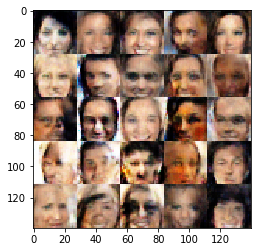

Epoch 1/1:	 Discriminator loss: 0.616	 Generator loss: 1.392
Epoch 1/1:	 Discriminator loss: 0.613	 Generator loss: 2.456
Epoch 1/1:	 Discriminator loss: 1.065	 Generator loss: 0.663
Epoch 1/1:	 Discriminator loss: 0.673	 Generator loss: 2.086
Epoch 1/1:	 Discriminator loss: 0.827	 Generator loss: 3.004
Epoch 1/1:	 Discriminator loss: 1.468	 Generator loss: 0.788
Epoch 1/1:	 Discriminator loss: 1.105	 Generator loss: 0.683
Epoch 1/1:	 Discriminator loss: 0.539	 Generator loss: 2.958
Epoch 1/1:	 Discriminator loss: 0.615	 Generator loss: 1.805
Epoch 1/1:	 Discriminator loss: 1.461	 Generator loss: 0.497


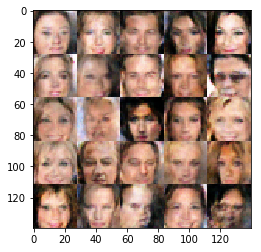

Epoch 1/1:	 Discriminator loss: 0.598	 Generator loss: 1.772
Epoch 1/1:	 Discriminator loss: 0.612	 Generator loss: 1.787
Epoch 1/1:	 Discriminator loss: 1.169	 Generator loss: 0.770
Epoch 1/1:	 Discriminator loss: 1.472	 Generator loss: 1.447
Epoch 1/1:	 Discriminator loss: 0.926	 Generator loss: 0.825
Epoch 1/1:	 Discriminator loss: 0.485	 Generator loss: 1.996
Epoch 1/1:	 Discriminator loss: 0.709	 Generator loss: 1.522
Epoch 1/1:	 Discriminator loss: 0.726	 Generator loss: 1.153
Epoch 1/1:	 Discriminator loss: 1.037	 Generator loss: 0.780
Epoch 1/1:	 Discriminator loss: 0.675	 Generator loss: 0.553


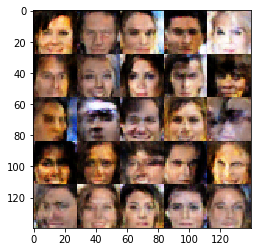

Epoch 1/1:	 Discriminator loss: 0.619	 Generator loss: 1.978
Epoch 1/1:	 Discriminator loss: 0.473	 Generator loss: 1.924
Epoch 1/1:	 Discriminator loss: 0.928	 Generator loss: 1.488
Epoch 1/1:	 Discriminator loss: 0.921	 Generator loss: 0.999
Epoch 1/1:	 Discriminator loss: 0.728	 Generator loss: 3.243
Epoch 1/1:	 Discriminator loss: 0.773	 Generator loss: 0.896
Epoch 1/1:	 Discriminator loss: 0.717	 Generator loss: 2.037
Epoch 1/1:	 Discriminator loss: 0.703	 Generator loss: 2.100
Epoch 1/1:	 Discriminator loss: 0.663	 Generator loss: 1.705
Epoch 1/1:	 Discriminator loss: 0.611	 Generator loss: 1.839


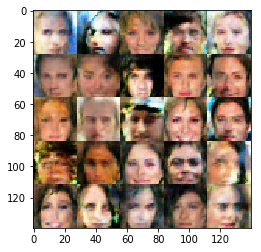

Epoch 1/1:	 Discriminator loss: 1.351	 Generator loss: 0.865
Epoch 1/1:	 Discriminator loss: 0.673	 Generator loss: 2.898
Epoch 1/1:	 Discriminator loss: 0.714	 Generator loss: 1.140
Epoch 1/1:	 Discriminator loss: 0.498	 Generator loss: 2.765
Epoch 1/1:	 Discriminator loss: 1.425	 Generator loss: 1.682
Epoch 1/1:	 Discriminator loss: 1.263	 Generator loss: 0.477
Epoch 1/1:	 Discriminator loss: 0.912	 Generator loss: 1.362
Epoch 1/1:	 Discriminator loss: 0.696	 Generator loss: 2.181
Epoch 1/1:	 Discriminator loss: 0.600	 Generator loss: 1.448
Epoch 1/1:	 Discriminator loss: 0.940	 Generator loss: 2.658


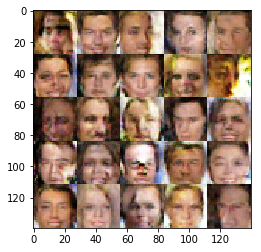

Epoch 1/1:	 Discriminator loss: 0.571	 Generator loss: 2.281
Epoch 1/1:	 Discriminator loss: 0.731	 Generator loss: 2.713
Epoch 1/1:	 Discriminator loss: 0.837	 Generator loss: 1.624
Epoch 1/1:	 Discriminator loss: 0.752	 Generator loss: 0.621
Epoch 1/1:	 Discriminator loss: 0.609	 Generator loss: 2.206
Epoch 1/1:	 Discriminator loss: 0.497	 Generator loss: 2.035
Epoch 1/1:	 Discriminator loss: 0.712	 Generator loss: 3.241
Epoch 1/1:	 Discriminator loss: 0.542	 Generator loss: 3.090
Epoch 1/1:	 Discriminator loss: 0.458	 Generator loss: 1.957
Epoch 1/1:	 Discriminator loss: 0.940	 Generator loss: 1.074


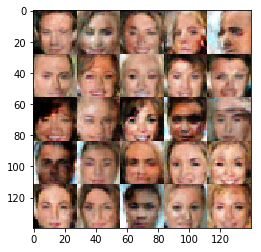

Epoch 1/1:	 Discriminator loss: 0.579	 Generator loss: 1.635
Epoch 1/1:	 Discriminator loss: 0.795	 Generator loss: 1.800
Epoch 1/1:	 Discriminator loss: 2.074	 Generator loss: 4.841
Epoch 1/1:	 Discriminator loss: 1.002	 Generator loss: 1.033
Epoch 1/1:	 Discriminator loss: 0.614	 Generator loss: 1.948
Epoch 1/1:	 Discriminator loss: 0.596	 Generator loss: 2.644
Epoch 1/1:	 Discriminator loss: 0.615	 Generator loss: 1.884
Epoch 1/1:	 Discriminator loss: 0.592	 Generator loss: 3.073
Epoch 1/1:	 Discriminator loss: 0.669	 Generator loss: 3.666
Epoch 1/1:	 Discriminator loss: 1.096	 Generator loss: 0.865


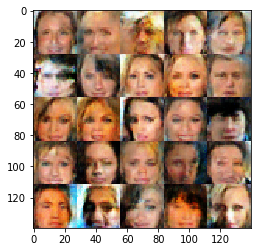

Epoch 1/1:	 Discriminator loss: 1.625	 Generator loss: 3.627
Epoch 1/1:	 Discriminator loss: 0.632	 Generator loss: 2.099
Epoch 1/1:	 Discriminator loss: 0.529	 Generator loss: 2.832
Epoch 1/1:	 Discriminator loss: 0.493	 Generator loss: 3.929
Epoch 1/1:	 Discriminator loss: 0.772	 Generator loss: 1.740
Epoch 1/1:	 Discriminator loss: 0.999	 Generator loss: 0.931
Epoch 1/1:	 Discriminator loss: 0.607	 Generator loss: 2.163
Epoch 1/1:	 Discriminator loss: 1.174	 Generator loss: 3.250
Epoch 1/1:	 Discriminator loss: 0.666	 Generator loss: 1.587
Epoch 1/1:	 Discriminator loss: 0.447	 Generator loss: 2.567


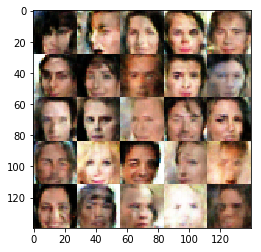

Epoch 1/1:	 Discriminator loss: 0.917	 Generator loss: 1.417
Epoch 1/1:	 Discriminator loss: 0.790	 Generator loss: 2.422
Epoch 1/1:	 Discriminator loss: 0.398	 Generator loss: 3.050
Epoch 1/1:	 Discriminator loss: 0.544	 Generator loss: 1.450
Epoch 1/1:	 Discriminator loss: 0.484	 Generator loss: 1.903
Epoch 1/1:	 Discriminator loss: 0.430	 Generator loss: 2.775
Epoch 1/1:	 Discriminator loss: 0.987	 Generator loss: 0.821
Epoch 1/1:	 Discriminator loss: 0.602	 Generator loss: 1.374
Epoch 1/1:	 Discriminator loss: 0.485	 Generator loss: 3.083
Epoch 1/1:	 Discriminator loss: 0.434	 Generator loss: 3.535


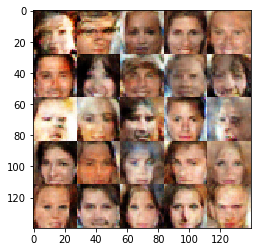

Epoch 1/1:	 Discriminator loss: 1.767	 Generator loss: 4.358
Epoch 1/1:	 Discriminator loss: 0.899	 Generator loss: 1.017
Epoch 1/1:	 Discriminator loss: 0.570	 Generator loss: 3.445
Epoch 1/1:	 Discriminator loss: 0.664	 Generator loss: 1.829
Epoch 1/1:	 Discriminator loss: 0.554	 Generator loss: 2.749
Epoch 1/1:	 Discriminator loss: 0.663	 Generator loss: 3.649
Epoch 1/1:	 Discriminator loss: 0.542	 Generator loss: 3.231
Epoch 1/1:	 Discriminator loss: 0.626	 Generator loss: 2.770
Epoch 1/1:	 Discriminator loss: 0.524	 Generator loss: 2.063
Epoch 1/1:	 Discriminator loss: 0.457	 Generator loss: 2.932


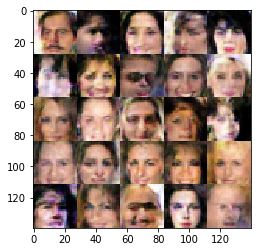

Epoch 1/1:	 Discriminator loss: 1.036	 Generator loss: 3.485
Epoch 1/1:	 Discriminator loss: 1.238	 Generator loss: 4.164
Epoch 1/1:	 Discriminator loss: 0.562	 Generator loss: 0.890
Epoch 1/1:	 Discriminator loss: 0.973	 Generator loss: 0.539
Epoch 1/1:	 Discriminator loss: 0.814	 Generator loss: 3.118
Epoch 1/1:	 Discriminator loss: 0.694	 Generator loss: 2.574
Epoch 1/1:	 Discriminator loss: 0.665	 Generator loss: 1.774
Epoch 1/1:	 Discriminator loss: 0.536	 Generator loss: 3.941
Epoch 1/1:	 Discriminator loss: 0.439	 Generator loss: 1.937
Epoch 1/1:	 Discriminator loss: 0.489	 Generator loss: 3.048


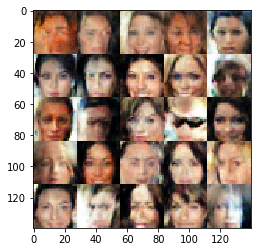

Epoch 1/1:	 Discriminator loss: 0.614	 Generator loss: 2.195
Epoch 1/1:	 Discriminator loss: 0.624	 Generator loss: 2.254
Epoch 1/1:	 Discriminator loss: 0.795	 Generator loss: 1.912
Epoch 1/1:	 Discriminator loss: 0.645	 Generator loss: 2.621
Epoch 1/1:	 Discriminator loss: 0.624	 Generator loss: 1.345
Epoch 1/1:	 Discriminator loss: 0.505	 Generator loss: 2.249
Epoch 1/1:	 Discriminator loss: 0.652	 Generator loss: 3.056
Epoch 1/1:	 Discriminator loss: 1.029	 Generator loss: 1.407
Epoch 1/1:	 Discriminator loss: 0.599	 Generator loss: 2.380
Epoch 1/1:	 Discriminator loss: 1.812	 Generator loss: 4.472


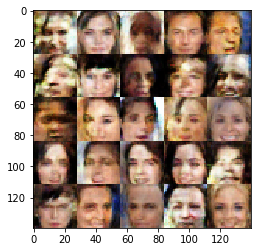

Epoch 1/1:	 Discriminator loss: 1.091	 Generator loss: 4.120
Epoch 1/1:	 Discriminator loss: 0.607	 Generator loss: 3.217
Epoch 1/1:	 Discriminator loss: 0.681	 Generator loss: 3.938
Epoch 1/1:	 Discriminator loss: 0.620	 Generator loss: 0.986
Epoch 1/1:	 Discriminator loss: 0.815	 Generator loss: 2.056
Epoch 1/1:	 Discriminator loss: 0.599	 Generator loss: 2.769
Epoch 1/1:	 Discriminator loss: 0.486	 Generator loss: 1.394
Epoch 1/1:	 Discriminator loss: 0.831	 Generator loss: 2.765
Epoch 1/1:	 Discriminator loss: 0.532	 Generator loss: 1.621
Epoch 1/1:	 Discriminator loss: 0.651	 Generator loss: 1.704


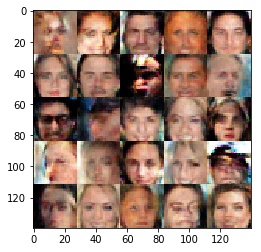

Epoch 1/1:	 Discriminator loss: 0.548	 Generator loss: 2.593
Epoch 1/1:	 Discriminator loss: 0.428	 Generator loss: 3.651
Epoch 1/1:	 Discriminator loss: 0.470	 Generator loss: 1.517
Epoch 1/1:	 Discriminator loss: 1.238	 Generator loss: 5.084
Epoch 1/1:	 Discriminator loss: 0.425	 Generator loss: 2.152
Epoch 1/1:	 Discriminator loss: 0.726	 Generator loss: 1.146
Epoch 1/1:	 Discriminator loss: 0.475	 Generator loss: 3.120
Epoch 1/1:	 Discriminator loss: 0.462	 Generator loss: 2.961
Epoch 1/1:	 Discriminator loss: 1.045	 Generator loss: 3.230
Epoch 1/1:	 Discriminator loss: 0.707	 Generator loss: 1.704


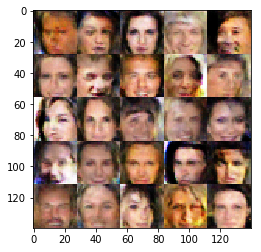

Epoch 1/1:	 Discriminator loss: 0.994	 Generator loss: 3.249
Epoch 1/1:	 Discriminator loss: 0.995	 Generator loss: 1.861
Epoch 1/1:	 Discriminator loss: 1.642	 Generator loss: 0.610
Epoch 1/1:	 Discriminator loss: 0.680	 Generator loss: 2.810
Epoch 1/1:	 Discriminator loss: 0.966	 Generator loss: 3.268
Epoch 1/1:	 Discriminator loss: 0.942	 Generator loss: 1.357
Epoch 1/1:	 Discriminator loss: 0.578	 Generator loss: 3.385
Epoch 1/1:	 Discriminator loss: 0.587	 Generator loss: 2.678
Epoch 1/1:	 Discriminator loss: 0.875	 Generator loss: 1.647
Epoch 1/1:	 Discriminator loss: 0.697	 Generator loss: 3.596


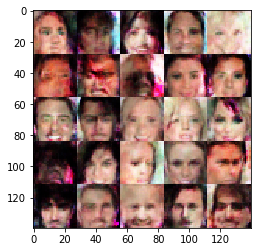

Epoch 1/1:	 Discriminator loss: 0.823	 Generator loss: 0.972
Epoch 1/1:	 Discriminator loss: 0.565	 Generator loss: 3.092
Epoch 1/1:	 Discriminator loss: 2.342	 Generator loss: 4.141
Epoch 1/1:	 Discriminator loss: 0.685	 Generator loss: 2.036
Epoch 1/1:	 Discriminator loss: 1.134	 Generator loss: 1.477
Epoch 1/1:	 Discriminator loss: 0.609	 Generator loss: 2.854
Epoch 1/1:	 Discriminator loss: 0.614	 Generator loss: 2.682
Epoch 1/1:	 Discriminator loss: 0.679	 Generator loss: 2.657
Epoch 1/1:	 Discriminator loss: 0.502	 Generator loss: 2.141
Epoch 1/1:	 Discriminator loss: 0.865	 Generator loss: 1.496


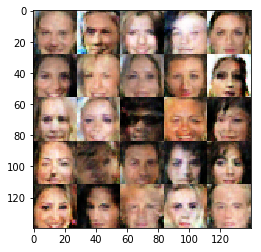

Epoch 1/1:	 Discriminator loss: 0.742	 Generator loss: 2.091
Epoch 1/1:	 Discriminator loss: 1.091	 Generator loss: 3.057
Epoch 1/1:	 Discriminator loss: 0.529	 Generator loss: 2.921
Epoch 1/1:	 Discriminator loss: 0.491	 Generator loss: 3.741
Epoch 1/1:	 Discriminator loss: 0.478	 Generator loss: 1.876
Epoch 1/1:	 Discriminator loss: 0.616	 Generator loss: 1.796
Epoch 1/1:	 Discriminator loss: 0.740	 Generator loss: 1.444
Epoch 1/1:	 Discriminator loss: 0.846	 Generator loss: 0.620
Epoch 1/1:	 Discriminator loss: 0.662	 Generator loss: 2.423
Epoch 1/1:	 Discriminator loss: 0.444	 Generator loss: 2.036


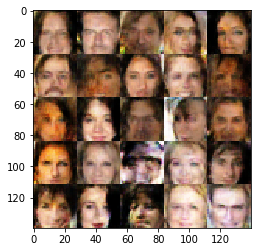

Epoch 1/1:	 Discriminator loss: 0.810	 Generator loss: 3.010
Epoch 1/1:	 Discriminator loss: 1.030	 Generator loss: 1.239
Epoch 1/1:	 Discriminator loss: 0.507	 Generator loss: 2.660
Epoch 1/1:	 Discriminator loss: 0.476	 Generator loss: 2.926
Epoch 1/1:	 Discriminator loss: 0.466	 Generator loss: 2.757
Epoch 1/1:	 Discriminator loss: 0.460	 Generator loss: 1.752
Epoch 1/1:	 Discriminator loss: 1.304	 Generator loss: 5.156
Epoch 1/1:	 Discriminator loss: 0.835	 Generator loss: 1.040
Epoch 1/1:	 Discriminator loss: 0.838	 Generator loss: 1.381
Epoch 1/1:	 Discriminator loss: 0.821	 Generator loss: 3.752


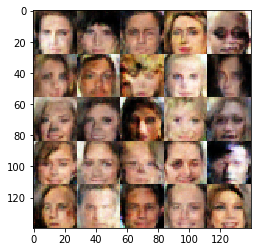

Epoch 1/1:	 Discriminator loss: 0.827	 Generator loss: 1.223
Epoch 1/1:	 Discriminator loss: 0.538	 Generator loss: 2.594
Epoch 1/1:	 Discriminator loss: 0.518	 Generator loss: 1.971
Epoch 1/1:	 Discriminator loss: 0.654	 Generator loss: 1.174
Epoch 1/1:	 Discriminator loss: 0.407	 Generator loss: 2.975
Epoch 1/1:	 Discriminator loss: 0.561	 Generator loss: 2.617
Epoch 1/1:	 Discriminator loss: 0.506	 Generator loss: 4.650
Epoch 1/1:	 Discriminator loss: 0.527	 Generator loss: 2.849
Epoch 1/1:	 Discriminator loss: 0.398	 Generator loss: 2.226
Epoch 1/1:	 Discriminator loss: 0.509	 Generator loss: 3.240


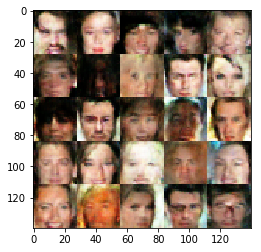

Epoch 1/1:	 Discriminator loss: 0.420	 Generator loss: 2.492
Epoch 1/1:	 Discriminator loss: 0.538	 Generator loss: 2.602
Epoch 1/1:	 Discriminator loss: 0.560	 Generator loss: 3.826
Epoch 1/1:	 Discriminator loss: 0.461	 Generator loss: 5.018
Epoch 1/1:	 Discriminator loss: 0.496	 Generator loss: 2.796
Epoch 1/1:	 Discriminator loss: 0.782	 Generator loss: 3.707
Epoch 1/1:	 Discriminator loss: 0.411	 Generator loss: 2.418
Epoch 1/1:	 Discriminator loss: 2.115	 Generator loss: 3.943
Epoch 1/1:	 Discriminator loss: 0.744	 Generator loss: 4.004
Epoch 1/1:	 Discriminator loss: 0.582	 Generator loss: 1.617


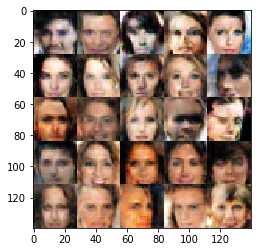

Epoch 1/1:	 Discriminator loss: 0.695	 Generator loss: 2.912
Epoch 1/1:	 Discriminator loss: 0.838	 Generator loss: 1.540
Epoch 1/1:	 Discriminator loss: 1.689	 Generator loss: 5.679
Epoch 1/1:	 Discriminator loss: 1.414	 Generator loss: 4.996
Epoch 1/1:	 Discriminator loss: 0.571	 Generator loss: 4.019
Epoch 1/1:	 Discriminator loss: 0.727	 Generator loss: 3.935
Epoch 1/1:	 Discriminator loss: 0.473	 Generator loss: 1.731
Epoch 1/1:	 Discriminator loss: 0.758	 Generator loss: 4.827
Epoch 1/1:	 Discriminator loss: 0.455	 Generator loss: 2.479
Epoch 1/1:	 Discriminator loss: 0.921	 Generator loss: 0.519


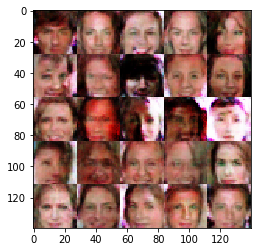

Epoch 1/1:	 Discriminator loss: 0.422	 Generator loss: 3.677
Epoch 1/1:	 Discriminator loss: 0.669	 Generator loss: 2.390
Epoch 1/1:	 Discriminator loss: 0.540	 Generator loss: 3.283
Epoch 1/1:	 Discriminator loss: 0.374	 Generator loss: 1.811
Epoch 1/1:	 Discriminator loss: 1.622	 Generator loss: 6.015
Epoch 1/1:	 Discriminator loss: 0.868	 Generator loss: 1.528
Epoch 1/1:	 Discriminator loss: 0.423	 Generator loss: 3.100
Epoch 1/1:	 Discriminator loss: 0.598	 Generator loss: 1.555
Epoch 1/1:	 Discriminator loss: 0.503	 Generator loss: 2.446
Epoch 1/1:	 Discriminator loss: 0.993	 Generator loss: 4.520


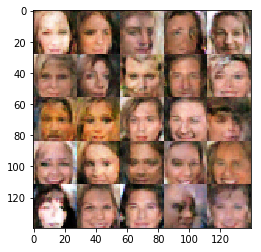

Epoch 1/1:	 Discriminator loss: 0.622	 Generator loss: 1.300
Epoch 1/1:	 Discriminator loss: 0.678	 Generator loss: 2.617
Epoch 1/1:	 Discriminator loss: 0.381	 Generator loss: 2.753


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.